# Import Dependencies

In [ ]:
import numpy as np
import pandas as pd
import gzip
import json

from pprint import pprint

In [ ]:
#@title Turkish StopWords

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
turkish_stopwords = stopwords.words('turkish')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:


from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Influencer Category Classification



1.   Read Data
2.   Preprocess Data
3.   Prepare Model
4.   Predict Test Data
4.   Save outputs



In [ ]:
train_classification_df = pd.read_csv("/content/drive/My Drive/Project/train-classification.csv",)
train_classification_df = train_classification_df.rename(columns={'Unnamed: 0': 'user_id', 'label': 'category'})

# Unifying labels
train_classification_df["category"] = train_classification_df["category"].apply(str.lower)
username2_category = train_classification_df.set_index("user_id").to_dict()["category"]

In [ ]:
# stats about the labels
train_classification_df.groupby("category").count()

,user_id
category,
art,191
entertainment,323
fashion,299
food,511
gaming,13
health and lifestyle,503
mom and children,149
sports,113
tech,346


In [ ]:


# Compute class weights
class_counts = {
    'art': 191,
    'entertainment': 323,
    'fashion': 299,
    'food': 511,
    'gaming': 13,
    'health and lifestyle': 503,
    'mom and children': 149,
    'sports': 113,
    'tech': 346,
    'travel': 294
}

total_samples = sum(class_counts.values())
num_classes = len(class_counts)

class_weights = {
    cls: total_samples / (num_classes * count) for cls, count in class_counts.items()
}
class_weights

{'art': 1.4356020942408376,
 'entertainment': 0.8489164086687306,
 'fashion': 0.9170568561872909,
 'food': 0.5365949119373777,
 'gaming': 21.092307692307692,
 'health and lifestyle': 0.5451292246520875,
 'mom and children': 1.840268456375839,
 'sports': 2.426548672566372,
 'tech': 0.792485549132948,
 'travel': 0.9326530612244898}

In [ ]:
username2_category["kod8net"]

'tech'

In [ ]:
train_data_path = "/content/drive/My Drive/Project/training-dataset.jsonl.gz"

username2posts_train = dict()
username2profile_train = dict()

username2posts_test = dict()
username2profile_test = dict()


with gzip.open(train_data_path, "rt") as fh:
  for line in fh:
    sample = json.loads(line)

    profile = sample["profile"]
    username = profile["username"]
    if username in username2_category:
      # train data info
      username2posts_train[username] = sample["posts"]
      username2profile_train[username] = profile


    else:
      # it is test data info
      username2posts_test[username] = sample["posts"]
      username2profile_test[username] = profile


In [ ]:
# Profile Dataframe
train_profile_df = pd.DataFrame(username2profile_train).T.reset_index(drop=True)
test_profile_df = pd.DataFrame(username2profile_test).T.reset_index(drop=True)

train_profile_df.head(2)

,username,id,full_name,biography,category_name,post_count,follower_count,following_count,is_business_account,is_private,...,business_category_name,overall_category_name,category_enum,is_verified_by_mv4b,is_regulated_c18,profile_pic_url,should_show_category,should_show_public_contacts,show_account_transparency_details,profile_picture_base64
0,deparmedya,3170700063,Depar Medya,#mediaplanning #mediabuying #sosyalmedya,Local business,None,1167,192,True,False,...,None,None,LOCAL,False,False,https://instagram.fsaw2-3.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
1,kafesfirin,266439571,KAFES FIRIN,📍Söğütözü📍FTZ AVM\n🛒Ankara macro▲center v...,Brand,None,11997,17,True,False,...,None,None,BRAND,False,False,https://instagram.fada1-13.fna.fbcdn.net/v/t51...,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...


In [ ]:
columns_to_drop = ['post_count', 'business_category_name', 'id', 'bio_links', 'eimu_id', 'fbid', 'business_address_json', 'business_contact_method', 'profile_pic_url', 'profile_picture_base64']
train_profile_df.drop(columns=columns_to_drop, inplace=True)

train_profile_df = train_profile_df.dropna(axis=1, how='all')

print(train_profile_df.info())
print(train_profile_df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2741 entries, 0 to 2740
Data columns (total 28 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   username                           2741 non-null   object
 1   full_name                          2715 non-null   object
 2   biography                          2571 non-null   object
 3   category_name                      2226 non-null   object
 4   follower_count                     2741 non-null   object
 5   following_count                    2741 non-null   object
 6   is_business_account                2741 non-null   object
 7   is_private                         2741 non-null   object
 8   is_verified                        2741 non-null   object
 9   highlight_reel_count               2741 non-null   object
 10  entities                           2571 non-null   object
 11  country_block                      2741 non-null   object
 12  extern

In [ ]:
columns_to_update = ['category_enum', 'biography', 'full_name', 'external_url', 'category_name']
train_profile_df[columns_to_update] = train_profile_df[columns_to_update].fillna('Unknown')

print(train_profile_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2741 entries, 0 to 2740
Data columns (total 28 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   username                           2741 non-null   object
 1   full_name                          2741 non-null   object
 2   biography                          2741 non-null   object
 3   category_name                      2741 non-null   object
 4   follower_count                     2741 non-null   object
 5   following_count                    2741 non-null   object
 6   is_business_account                2741 non-null   object
 7   is_private                         2741 non-null   object
 8   is_verified                        2741 non-null   object
 9   highlight_reel_count               2741 non-null   object
 10  entities                           2571 non-null   object
 11  country_block                      2741 non-null   object
 12  extern

<ipython-input-10-6053bcd828c3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_profile_df[columns_to_update] = train_profile_df[columns_to_update].fillna('Unknown')


In [ ]:
# Adding a category column based on username2_category
train_profile_df['category'] = [
    username2_category.get(uname, "NA") for uname in train_profile_df['username']
]


<ipython-input-11-e3e6c8eafa54>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_profile_df['category'] = [


In [ ]:
# Convert columns with only `True` or `False` to boolean
for col in train_profile_df.columns:
    if train_profile_df[col].dropna().isin([True, False]).all():  # Check for True/False values
        train_profile_df[col] = train_profile_df[col].astype(bool)

<ipython-input-12-a8ac6fe8cfcf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_profile_df[col] = train_profile_df[col].astype(bool)
<ipython-input-12-a8ac6fe8cfcf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_profile_df[col] = train_profile_df[col].astype(bool)
<ipython-input-12-a8ac6fe8cfcf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Convert 'follower_count', 'following_count', 'highlight_reel_count' to integers
train_profile_df['follower_count'] = pd.to_numeric(train_profile_df['follower_count'], errors='coerce')
train_profile_df['following_count'] = pd.to_numeric(train_profile_df['following_count'], errors='coerce')
train_profile_df['highlight_reel_count'] = pd.to_numeric(train_profile_df['highlight_reel_count'], errors='coerce')

# Encode 'category_name' using Label Encoding
label_encoder = LabelEncoder()
train_profile_df['category_name_encoded'] = label_encoder.fit_transform(train_profile_df['category_name'])

# Encode 'category_enum' using Label Encoding
train_profile_df['category_enum'] = label_encoder.fit_transform(train_profile_df['category_enum'])
train_profile_df['category_encoded'] = label_encoder.fit_transform(train_profile_df['category'])
# Optional: Check the data types to verify the changes
print(train_profile_df.dtypes)


username                             object
full_name                            object
biography                            object
category_name                        object
follower_count                        int64
following_count                       int64
is_business_account                    bool
is_private                             bool
is_verified                            bool
highlight_reel_count                  int64
entities                             object
country_block                          bool
external_url                         object
has_clips                              bool
hide_like_and_view_counts              bool
is_professional_account                bool
is_supervision_enabled                 bool
is_guardian_of_viewer                  bool
is_supervised_by_viewer                bool
is_supervised_user                     bool
is_embeds_disabled                     bool
is_joined_recently                     bool
category_enum                   

In [ ]:
pip install transformers datasets torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Use a multilingual RoBERTa model, or replace with a Turkish-specific RoBERTa if available
model_name = "FacebookAI/xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=10)  # Set num_labels based on your task


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re




# Prepare training data
train_usernames = []
corpus = []

for username, posts in username2posts_train.items():
    train_usernames.append(username)  # Keep track of usernames

    # Aggregate posts per user
    cleaned_captions = []
    for post in posts:
        post_caption = post.get("caption", "")
        if post_caption is None:
            continue

        if post_caption != "":
            cleaned_captions.append(post_caption)

    # Join the posts of each user
    user_post_captions = "\n".join(cleaned_captions)
    corpus.append(user_post_captions)




# Map usernames to their categories
y_train = [username2_category.get(username, "NA") for username in train_usernames]




# Prepare test data
test_usernames = []
test_corpus = []

for username, posts in username2posts_test.items():
    test_usernames.append(username)  # Keep track of usernames

    # Aggregate posts per user
    cleaned_captions = []
    for post in posts:
        post_caption = post.get("caption", "")
        if post_caption is None:
            continue

        if post_caption != "":
            cleaned_captions.append(post_caption)

    # Join the posts of each user
    user_post_captions = "\n".join(cleaned_captions)
    test_corpus.append(user_post_captions)


# Map test usernames to their categories
y_test = [username2_category.get(username, "NA") for username in test_usernames]

# Combine data with usernames
train_data = {
    "username": train_usernames,
    "features": corpus,
    "labels": y_train
}

test_data = {
    "username": test_usernames,
    "features": test_corpus,
    "labels": y_test
}


# Combine data with usernames
train_data = {
    "username": train_usernames,
    "features": corpus,
    "labels": y_train
}

train_df = pd.DataFrame(train_data)
train_df.head()


test_df = pd.DataFrame(test_data)

In [ ]:
import torch
from transformers import MarianMTModel, MarianTokenizer
import pandas as pd
from tqdm import tqdm

# Load the pre-trained translation model and tokenizer for Turkish to English
model_name = 'Helsinki-NLP/opus-mt-tc-big-tr-en'  # You can use the smaller version if needed
model = MarianMTModel.from_pretrained(model_name).to("cuda")  # Ensure it's loaded on GPU
tokenizer = MarianTokenizer.from_pretrained(model_name)

# Function to translate Turkish text to English
def translate_batch(batch_texts, model, tokenizer, batch_size=16):
    inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = inputs.to("cuda")  # Move inputs to GPU
    with torch.no_grad():  # Disable gradient calculations to save memory during inference
        translated = model.generate(**inputs)
    return tokenizer.batch_decode(translated, skip_special_tokens=True)

# Function to apply translation with progress
def translate_with_progress(df, model, tokenizer, batch_size=16):
    # List to hold translated texts
    translated_texts = []

    # Process the data in batches
    for i in tqdm(range(0, len(df), batch_size), desc="Translating"):
        batch_texts = df['features'][i:i + batch_size].tolist()  # Get the next batch of texts
        translated_batch = translate_batch(batch_texts, model, tokenizer, batch_size)
        translated_texts.extend(translated_batch)  # Add the translated batch to the list

        # Clear cache after each batch
        torch.cuda.empty_cache()

    # Add the translated texts to the DataFrame
    df['features_translated'] = translated_texts
    return df


# Apply the translation with progress tracking
train_df = translate_with_progress(train_df, model, tokenizer, batch_size=16)

# Print the translated results
print(train_df[['features', 'features_translated']])


Translating: 100%|██████████| 172/172 [1:16:53<00:00, 26.82s/it]

                                               features  \
0     Cumhuriyetimizin 100.yılı kutlu olsun♾️🇹🇷\nOri...   
1     Bugün bir fincan köpüklü Türk kahvesiyle taçla...   
2     Saygı ve özlemle🖤\n\n#atatürk #10kasım #10kasi...   
3     📍Altınoluk\n\nÇevre, Şehircilik ve İklim Değiş...   
4     Güne enerjik bir sohbet ile devam etmek ister ...   
...                                                 ...   
2736  emelaydinbutikpastacilik butik.pastacilar.dern...   
2737  #berliner #almanekmeği #hercumartesi\n#AlmanBa...   
2738  “Bu söylediklerim hakikat olduğu gün, senden v...   
2739  NETS VADİDE NEFES KAMPI 16-17 ARALIK\nAz sayıd...   
2740  Gurdjieff kutsal dansları ve öğretisi çalışmas...   

                                    features_translated  
0      Happy 100th anniversary of our Republic Oriflame  
1     Let's celebrate today with a cup of sparkling ...  
2     With respect and longing #atamartürk #10kaşım ...  
3     We congratulate our Eskişoluk Environment, Urb...  
4

In [ ]:
# Define the path where you want to save the file in your Google Drive
save_path = '/content/drive/My Drive/Project/translated_train_df.csv'

# Save the DataFrame to the specified location
train_df.to_csv(save_path, index=False)
print(f"File saved to {save_path}")


NameError: name 'train_df' is not defined

In [ ]:
import pandas as pd

# If you've uploaded a file, it will be available under '/content'
uploaded_file = '/content/drive/My Drive/Project/translated_train_df.csv'

# Load the file into a DataFrame
train_df = pd.read_csv(uploaded_file)

# Verify the loaded data
print(train_df.head())
train_df['features_translated'] =  train_df['features_translated'].astype(str)
train_df['labels'] =  train_df['labels'].astype(str)

               username                                           features  \
0            deparmedya  Cumhuriyetimizin 100.yılı kutlu olsun♾️🇹🇷\nOri...   
1            kafesfirin  Bugün bir fincan köpüklü Türk kahvesiyle taçla...   
2              vimerang  Saygı ve özlemle🖤\n\n#atatürk #10kasım #10kasi...   
3     mustafa_yalcinn38  📍Altınoluk\n\nÇevre, Şehircilik ve İklim Değiş...   
4  zorluenergysolutions  Güne enerjik bir sohbet ile devam etmek ister ...   

                 labels                                features_translated  
0                  tech   Happy 100th anniversary of our Republic Oriflame  
1                  food  Let's celebrate today with a cup of sparkling ...  
2                  tech  With respect and longing #atamartürk #10kaşım ...  
3  health and lifestyle  We congratulate our Eskişoluk Environment, Urb...  
4                  tech  Would you like to continue your day with an en...  


In [ ]:


label_encoder = LabelEncoder()

train_df['labels_encoded'] = label_encoder.fit_transform(train_df['labels'])


test_df['labels_encoded'] = label_encoder.fit_transform(test_df['labels'])

NameError: name 'test_df' is not defined

In [ ]:
from datasets import Dataset
import pandas as pd
from sklearn.model_selection import train_test_split


# Step 1: Prepare DataFrame
df = pd.DataFrame({
    'text': train_df["features_translated"],        # Text or features column
    'labels': train_df['labels_encoded'],  # Encoded labels
    'username': train_df['username']    # Include the username column
})

# 1. Split the data into train and validation sets (80% train, 20% validation)
train_df, val_df = train_test_split(df, test_size=0.55, random_state=42, stratify=df['labels'])

# 2. Optionally, if you want to simulate a test set:
# You can split 10% of the validation data into a test set
val_df, test_df = train_test_split(val_df, test_size=0.9, random_state=42, stratify=val_df['labels'])

# 3. Convert the DataFrames into HuggingFace Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

for dataset in [train_dataset, val_dataset, test_dataset]:
    if "__index_level_0__" in dataset.column_names:
        dataset = dataset.remove_columns("__index_level_0__")



In [ ]:
from transformers import AutoTokenizer

# Model name (ModernBERT in this case)
model_name = "answerdotai/ModernBERT-base"

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenization helper function
def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', max_length=1028,truncation=True, return_tensors="pt")

# Apply tokenization to the datasets
tokenized_train_dataset = train_dataset.map(tokenize, batched=True, remove_columns=["text"])
tokenized_val_dataset = val_dataset.map(tokenize, batched=True, remove_columns=["text"])
tokenized_test_dataset = test_dataset.map(tokenize, batched=True, remove_columns=["text"])

# Inspect tokenized dataset (optional)
print(tokenized_train_dataset[0])  # Show a sample of the tokenized data


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

Map:   0%|          | 0/1233 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/1358 [00:00<?, ? examples/s]

{'labels': 9, 'username': 'visitsplit', '__index_level_0__': 1403, 'input_ids': [50281, 12547, 634, 3858, 285, 15917, 634, 9908, 1852, 1344, 912, 634, 27690, 1852, 1344, 912, 634, 27690, 1852, 1344, 912, 634, 27690, 1852, 1344, 912, 634, 27690, 1852, 1344, 912, 634, 27690, 1852, 1344, 912, 634, 27690, 1852, 296, 2370, 1852, 1344, 912, 634, 27690, 1852, 1344, 912, 634, 27690, 1852, 1344, 912, 1852, 1344, 912, 634, 27690, 1852, 84, 1852, 1344, 912, 1852, 1344, 912, 1852, 1344, 912, 1852, 296, 2370, 1852, 296, 2370, 1852, 1344, 912, 1852, 296, 2370, 1852, 296, 2370, 1852, 296, 2370, 1852, 296, 2370, 1852, 296, 2370, 1852, 296, 2370, 1852, 296, 2370, 1852, 296, 2370, 1852, 296, 2370, 1852, 296, 2370, 1852, 296, 2370, 1852, 296, 2370, 1852, 296, 2370, 1852, 296, 2370, 1852, 296, 2370, 1852, 296, 2370, 1852, 296, 2370, 1852, 296, 2370, 1852, 296, 2370, 1852, 296, 2370, 1852, 296, 2370, 1852, 296, 2370, 1852, 296, 2370, 1852, 296, 2370, 1852, 296, 2370, 1852, 296, 2370, 1852, 296, 2370, 1852,

In [ ]:
train_dataset.features["labels"]

Value(dtype='string', id=None)

In [ ]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score

from transformers import AutoModelForSequenceClassification

# Model id to load the tokenizer
model_id = "answerdotai/ModernBERT-base"  # This can be your desired pre-trained model

unique_labels = np.unique(train_df['labels'])  # Assuming 'labels_encoded' column contains your labels
num_labels = len(unique_labels)

# Create the label2id and id2label mappings
label2id, id2label = dict(), dict()
for i, label in enumerate(unique_labels):
    label2id[str(label)] = int(i)  # Convert label to string and id to standard int
    id2label[int(i)] = str(label)  # Convert id to standard int

# Download the model from huggingface.co/models
model = AutoModelForSequenceClassification.from_pretrained(
    model_id,
    num_labels=num_labels,
    label2id=label2id,
    id2label=id2label
)


# Now the model is prepared for training and inference


# 2. Define evaluation metrics (F1 score)
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.argmax(axis=-1)  # Convert logits to predicted label IDs
    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1': f1_score(labels, predictions, average="weighted")
    }




config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification
import torch
import torch.nn as nn
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from datasets import Dataset

# Step 1: Compute class weights
# Assuming `train_labels` contains the labels for your training dataset.
# You can extract labels from train_dataset like this:
train_labels = np.array(tokenized_train_dataset['labels'])

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Move class weights to the same device as the model (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = class_weights.to(device)
from transformers import Trainer
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding

# Step 2: Modify Trainer to use custom loss function
class CustomTrainer(Trainer):

    def compute_loss(self, model, inputs, return_outputs=False,num_items_in_batch=0):
      # Extract labels from inputs
      labels = inputs.pop("labels").to(device)  # Ensure labels are on the correct device

      # Forward pass
      outputs = model(**inputs)
      logits = outputs.logits

      # Custom loss with class weights
      loss_fct = nn.CrossEntropyLoss(weight=class_weights)
      loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

      return (loss, outputs) if return_outputs else loss


In [ ]:
from huggingface_hub import HfFolder
from transformers import Trainer, TrainingArguments
from sklearn.metrics import f1_score



from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="ModernBERT-domain-classifier",  # Checkpoint directory
    per_device_train_batch_size=4,             # Reduce batch size further
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=16,             # Accumulate gradients for 8 steps (larger effective batch size)
    learning_rate=5e-4,
    num_train_epochs=10,
    bf16=True,                                 # Enable mixed precision for reduced memory
    optim="adamw_torch_fused",                 # Optimizer for efficient memory usage
    logging_strategy="steps",
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    push_to_hub=False,                         # Disable pushing to the hub
)
                  # Get token to push to the hub


# Create a Trainer instance
trainer = CustomTrainer(
    model=model,                                        # The pre-trained model
    args=training_args,                                 # Training arguments
    train_dataset=tokenized_train_dataset,              # Tokenized train dataset
    eval_dataset=tokenized_val_dataset,                 # Tokenized validation dataset
    compute_metrics=compute_metrics,                    # Compute metrics (F1 score)
)

# Start training
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1
0,No log,2.172958,0.240000,0.237351
1,No log,2.231993,0.313333,0.298130
2,No log,2.565699,0.346667,0.339232
3,No log,3.112215,0.366667,0.375661


In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


In [ ]:
import torch
torch.cuda.empty_cache()


In [ ]:

# Install Hugging Face libraries
%pip install  --upgrade \
  "datasets==3.1.0" \
  "accelerate==1.2.1" \
  "hf-transfer==0.1.8"

# ModernBERT is not yet available in an official release, so we need to install it from github
%pip install "git+https://github.com/huggingface/transformers.git@6e0515e99c39444caae39472ee1b2fd76ece32f1" --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
  Cloning https://github.com/huggingface/transformers.git (to revision 6e0515e99c394

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2741 entries, 0 to 2740
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   username             2741 non-null   object
 1   features             2736 non-null   object
 2   labels               2741 non-null   object
 3   features_translated  2556 non-null   object
dtypes: object(4)
memory usage: 85.8+ KB


In [ ]:
from transformers import AutoModelForSequenceClassification

# Prepare the model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(df['labels'].unique()),  # Number of unique labels
    label2id={label: i for i, label in enumerate(df['labels'].unique())},  # Label to ID mapping
    id2label={i: label for i, label in enumerate(df['labels'].unique())}   # ID to label mapping
)

# Check the model architecture (optional)
print(model)


In [ ]:
from datasets import Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
# Assume you have a DataFrame with 'text' and 'label' columns
df = pd.DataFrame({
    'text': train_df["features"],  # Replace with your text column
    'labels': train_df['labels_encoded']  # Use label-encoded categories
})

# 1. Split the data into train and validation sets (80% train, 20% validation)
train_df, val_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['labels'])

# 2. Optionally, if you want to simulate a test set:
# You can split 10% of the validation data into a test set
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42, stratify=val_df['labels'])

# 3. Convert the DataFrames into HuggingFace Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)




KeyError: 'features'

In [ ]:
from datasets import Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
# Assume you have a DataFrame with 'text' and 'label' columns
df = pd.DataFrame({
    'text': train_df["features"],  # Replace with your text column
    'labels': train_df['labels_encoded']  # Use label-encoded categories
})

# 1. Split the data into train and validation sets (80% train, 20% validation)
train_df, val_df = train_test_split(df, test_size=0.15, random_state=42, stratify=df['labels'])


# 3. Convert the DataFrames into HuggingFace Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

df_2 = pd.DataFrame({
    'text': test_df["features"],  # Replace with your text column
    'labels': test_df['labels_encoded']  # Use label-encoded categories
})
test_dataset = Dataset.from_pandas(df_2)


In [ ]:
val_dataset

Dataset({
    features: ['text', 'labels', 'username', '__index_level_0__'],
    num_rows: 1357
})

In [ ]:
test_dataset

Dataset({
    features: ['text', 'labels', '__index_level_0__'],
    num_rows: 151
})

In [ ]:
train_dataset = train_dataset.remove_columns(["__index_level_0__"])

val_dataset = val_dataset.remove_columns(["__index_level_0__"])

In [ ]:

test_dataset = test_dataset.remove_columns(["__index_level_0__"])

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset  # Hugging Face's datasets library


# Define the tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,  # Truncate to max_length
        max_length=512    # Ensure inputs fit model
    )

# Apply tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)
# Remove text columns after tokenization
train_dataset = train_dataset.remove_columns(["text"])
val_dataset = val_dataset.remove_columns(["text"])
test_dataset = test_dataset.remove_columns(["text"])
# Set the format for PyTorch
train_dataset.set_format("torch")
val_dataset.set_format("torch")
test_dataset.set_format("torch")

Map:   0%|          | 0/1233 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/1358 [00:00<?, ? examples/s]

In [ ]:
test_usernames = test_dataset["username"]  # Extract usernames

In [ ]:
print(train_dataset["attention_mask"][1])  # Look at the first 5 examples to ensure the "text" field is correct


tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
from transformers import AutoModelForSequenceClassification

num_labels = len(df['labels'].unique())  # Number of unique categories
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
pip install wandb

In [ ]:
from sklearn.metrics import accuracy_score
def compute_metrics(p):
    # p contains two arguments: predictions and labels
    predictions, labels = p
    # Use the argmax to get the predicted label from the logits (output of the model)
    preds = predictions.argmax(axis=-1)
    # Calculate accuracy
    acc = accuracy_score(labels, preds)
    return {"eval_accuracy": acc}


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Ensure 'label' is a NumPy array and extract unique classes
labels = np.array(train_dataset['labels'])
unique_classes = np.unique(labels)

print("Unique Classes:", unique_classes)

# Compute class weights
try:
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=unique_classes,
        y=labels
    )
    print("Class Weights:", class_weights)
except ValueError as e:
    print("Error:", e)

    # Debug: Check for missing or extra classes
    labels_in_data = set(labels)
    labels_in_classes = set(unique_classes)
    print("Labels in Data:", labels_in_data)
    print("Labels in Classes:", labels_in_classes)

    # Re-compute with corrected unique classes
    corrected_classes = np.array(list(labels_in_data))
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=corrected_classes,
        y=labels
    )
    print("Corrected Class Weights:", class_weights)


Unique Classes: [0 1 2 3 4 5 6 7 8 9]
Class Weights: [ 1.43372093  0.85034483  0.92014925  0.53608696 20.55        0.54557522
  1.84029851  2.41764706  0.79038462  0.93409091]


In [ ]:
print(val_dataset[0])  # Should include 'input_ids', 'attention_mask', and 'labels'


{'labels': tensor(2), 'username': 'ekinsarigul', '__index_level_0__': tensor(1797), 'input_ids': tensor([     0, 206613,  31411,  72505,     85,    496,  19310,   2327,   1099,
         15986,  62628, 244314,  79500,      6,      3,  42173,  25259,      6,
         95491,  14223,      5,      5,    468,     31,    818,     71,    468,
          6056,  16086,  40946,  54571,    112, 142051,  33941,  71457,    320,
          1099, 179114,     11,  97190,    316,      5,    468,     31,    818,
            71,    468,     31,    818,     71, 148472,    468,    107, 161466,
          1460,   4942,    266,  39482,   3948,   1010,     92,      6,      3,
           241,   7743,  48274,  47408, 129390,     92,  98918,   7124,    112,
           468,   1106,   6493,     33,  34869,  30368,  12222,  34869,    277,
           468,     85,   3618,    947,    875,  18865,      4,     47,   2500,
          5259,  78499,      6,      3,  84385,  44464,  26167, 101636,     39,
            28, 121505,

In [ ]:
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification
import torch
import torch.nn as nn
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from datasets import Dataset

# Step 1: Compute class weights
# Assuming `train_labels` contains the labels for your training dataset.
# You can extract labels from train_dataset like this:
train_labels = np.array(train_dataset['labels'])

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Move class weights to the same device as the model (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = class_weights.to(device)

# Step 2: Modify Trainer to use custom loss function
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False,num_items_in_batch=0):
        # Extract labels from inputs
        labels = inputs.pop("labels").to(device)  # Ensure labels are on the correct device

        # Forward pass
        outputs = model(**inputs)
        logits = outputs.logits

        # Custom loss with class weights
        loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss


In [ ]:
from transformers import Trainer, TrainingArguments
# Step 2: Modify training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="steps",  # Evaluate more frequently (adjust `eval_steps` below)
    save_strategy="steps",
    logging_dir="./logs",
    num_train_epochs=6,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    weight_decay=0.01,
    learning_rate=3e-5,  # Use a smaller learning rate for stability
    lr_scheduler_type="linear",  # Linear decay of learning rate
    warmup_steps=100,  # Gradually increase learning rate for first 100 steps
    logging_steps=50,  # Log training progress every 50 steps
    evaluation_strategy="steps",  # Evaluate on the validation set every few steps
    eval_steps=50,  # Adjust based on dataset size
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    report_to="wandb"
)

# Step 3: Update Trainer to use custom loss function
from transformers import Trainer


# Step 4: Create the Custom Trainer object
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics  # Use the same metrics function
)

# Step 5: Train the model
trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# Save the trained model
trainer.save_model("/content/drive/My Drive/Project/saved_model__weighted_large")  # Specify the directory where the model should be saved

# Save the tokenizer (to make sure the tokenizer used during training is also saved)
tokenizer.save_pretrained("/content/drive/My Drive/Project/saved_model_token_weighted_large")  # This will save the tokenizer in the same directory


('/content/drive/My Drive/Project/saved_model_token_weighted_large/tokenizer_config.json',
 '/content/drive/My Drive/Project/saved_model_token_weighted_large/special_tokens_map.json',
 '/content/drive/My Drive/Project/saved_model_token_weighted_large/sentencepiece.bpe.model',
 '/content/drive/My Drive/Project/saved_model_token_weighted_large/added_tokens.json',
 '/content/drive/My Drive/Project/saved_model_token_weighted_large/tokenizer.json')

In [ ]:
# Save the trained model
trainer.save_model("/content/drive/My Drive/Project/saved_model")  # Specify the directory where the model should be saved

# Save the tokenizer (to make sure the tokenizer used during training is also saved)
tokenizer.save_pretrained("/content/drive/My Drive/Project/saved_model_token")  # This will save the tokenizer in the same directory


('/content/drive/My Drive/Project/saved_model_token/tokenizer_config.json',
 '/content/drive/My Drive/Project/saved_model_token/special_tokens_map.json',
 '/content/drive/My Drive/Project/saved_model_token/sentencepiece.bpe.model',
 '/content/drive/My Drive/Project/saved_model_token/added_tokens.json',
 '/content/drive/My Drive/Project/saved_model_token/tokenizer.json')

In [ ]:
from transformers import AutoModelForSequenceClassification

# Load the model from the saved directory
model_path = "/content/drive/My Drive/Project/saved_model__weighted_large"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
from transformers import AutoTokenizer

# Load the tokenizer from the saved directory
tokenizer_path = "/content/drive/My Drive/Project/saved_model_token_weighted_large"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
# Get predictions



In [ ]:
# Tokenize the input
inputs = tokenizer(
    text,
    padding="max_length",
    truncation=True,
    max_length=512,  # Adjust based on your model's max length
    return_tensors="pt"  # Return PyTorch tensors
)

# Get predictions
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = logits.argmax(dim=1).item()

In [ ]:
from transformers import AutoModelForSequenceClassification

# Load the model from the saved directory
model_path = "/content/drive/My Drive/Project/saved_model_weighted"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
from transformers import AutoTokenizer

# Load the tokenizer from the saved directory
tokenizer_path = "/content/drive/My Drive/Project/saved_model_token_weighted"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
# Get predictions



In [ ]:
# Define tokenization function
def tokenize_function(examples):
    return tokenizer(
        test_dataset["text"],  # Adjust if the column name is different
        padding="max_length",
        truncation=True,
        max_length=512,  # Match your model's max length
    )


# Remove text columns after tokenization
test_dataset = test_dataset.remove_columns(["text"])  # Adjust column name as needed

# Set format for PyTorch
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


In [ ]:
probabilities_df = None


In [ ]:
import pandas as pd
import numpy as np

# Step 1: Get predictions and probabilities
predictions = trainer.predict(test_dataset)
logits = predictions.predictions

# Step 2: Calculate probabilities and predicted classes
probabilities = np.exp(logits) / np.exp(logits).sum(axis=-1, keepdims=True)
predicted_classes = probabilities.argmax(axis=-1)

# Step 3: Save to DataFrame
# Assuming test_dataset has a column "username"
usernames = test_dataset['username']

# Create a DataFrame with probabilities and predictions
probabilities_df = pd.DataFrame()
probabilities_df['predicted_class'] = predicted_classes
probabilities_df['username'] = usernames

# Step 4: Merge with train_profile_df
merged_df = train_profile_df.merge(probabilities_df, on="username", how="right")

# Step 5: Save or inspect the merged DataFrame
merged_df.to_csv("merged_with_probabilities.csv", index=False)
merged_df.head()


,username,full_name,biography,category_name,follower_count,following_count,is_business_account,is_private,is_verified,highlight_reel_count,...,category_enum,is_verified_by_mv4b,is_regulated_c18,should_show_category,should_show_public_contacts,show_account_transparency_details,category,category_name_encoded,category_encoded,predicted_class
0,galerist,Marat Guelman,Unknown,Producer,5635,750,True,False,False,0,...,209,False,False,True,False,True,art,249,0,0
1,dr.emekkulur,Emek Külür,🦷 | Smile Institute Aesthetic Dentistry\n☎️ | ...,Unknown,107490,1206,False,False,True,52,...,299,False,False,True,True,True,health and lifestyle,319,5,5
2,adasan_contract_furniture,ADASAN,@yaaz.official,Furniture,6655,356,True,False,False,12,...,120,False,False,True,True,True,health and lifestyle,135,5,2
3,tribundergi,Tribun Dergi,Tribün Kültürü Üzerine Her Şey\n(WhatsApp +905...,Media/news company,50976,2243,True,False,False,4,...,166,False,False,True,True,True,sports,194,7,7
4,olymposteleferik2365m,Olympos Teleferik,🚠 Embrace sky at Olympos Teleferik 2365 m.,Product/service,6709,6,True,False,False,7,...,299,False,False,False,False,True,travel,250,9,9


<ipython-input-64-5e397540dbd8>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


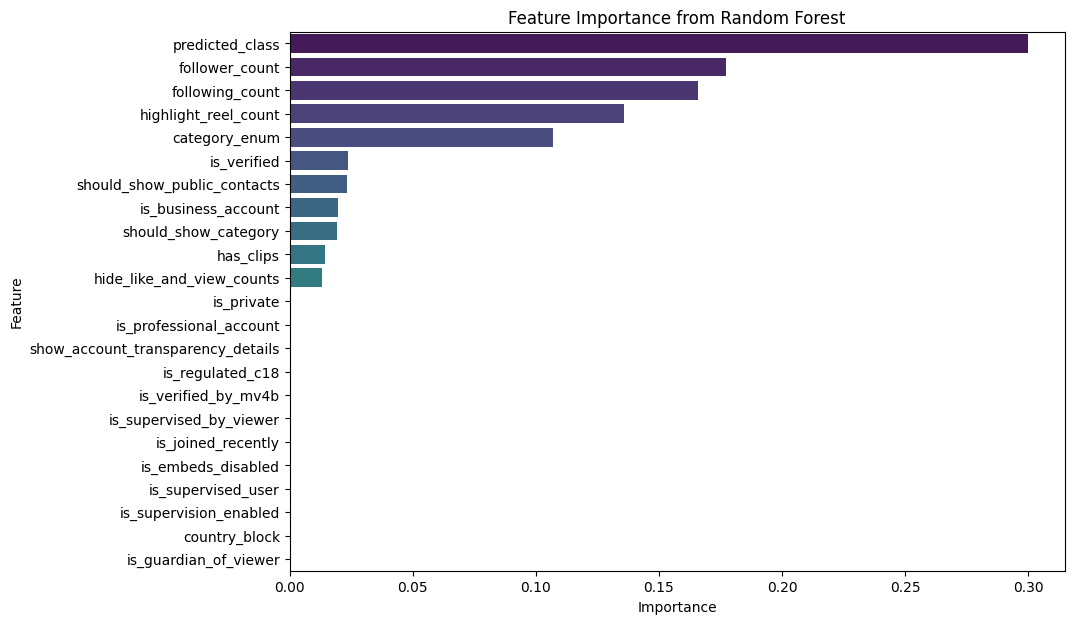

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

# Step 1: Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Step 2: Extract feature importances
importances = rf_model.feature_importances_

# Step 3: Create a DataFrame to associate features with their importances
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 4: Plot the feature importances
plt.figure(figsize=(10, 7))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [ ]:
from transformers import Trainer, TrainingArguments

# Define evaluation arguments
training_args = TrainingArguments(
    output_dir="./results",  # Directory to save evaluation results
    per_device_eval_batch_size=32,  # Batch size for evaluation
    logging_dir="./logs",  # Directory to save logs
)

# Create a Trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=test_dataset,
)

# Evaluate the model
results = trainer.evaluate()
print(results)


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset  # Hugging Face's datasets library


# Define the tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,  # Truncate to max_length
        max_length=256   # Ensure inputs fit model
    )

# Apply tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)
# Remove text columns after tokenization
train_dataset = train_dataset.remove_columns(["text"])
val_dataset = val_dataset.remove_columns(["text"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
# Set the format for PyTorch
train_dataset.set_format("torch")
val_dataset.set_format("torch")
test_dataset.set_format("torch")

In [ ]:
# Save the trained model
trainer.save_model("/content/drive/My Drive/Project/saved_model_weighted")  # Specify the directory where the model should be saved

# Save the tokenizer (to make sure the tokenizer used during training is also saved)
tokenizer.save_pretrained("/content/drive/My Drive/Project/saved_model_token_weighted")  # This will save the tokenizer in the same directory


('/content/drive/My Drive/Project/saved_model_token_weighted/tokenizer_config.json',
 '/content/drive/My Drive/Project/saved_model_token_weighted/special_tokens_map.json',
 '/content/drive/My Drive/Project/saved_model_token_weighted/sentencepiece.bpe.model',
 '/content/drive/My Drive/Project/saved_model_token_weighted/added_tokens.json',
 '/content/drive/My Drive/Project/saved_model_token_weighted/tokenizer.json')

In [ ]:
from transformers import Trainer
import torch

# Step 1: Evaluate the model on the test dataset
test_results = trainer.evaluate(test_dataset)

# Print evaluation results (e.g., accuracy, loss)
print("Test Results:", test_results)

# Step 2: Make predictions on the test dataset
predictions = trainer.predict(test_dataset)

# Get predicted labels (logits -> class predictions)
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), dim=-1)

# Print the predicted labels
print("Predicted Labels:", predicted_labels)

# Step 3: Compare predictions with true labels (Optional)
true_labels = torch.tensor(test_dataset["labels"])

# Calculate accuracy or any other metric
accuracy = (predicted_labels == true_labels).float().mean()

print(f"Accuracy: {accuracy:.4f}")


Test Results: {'eval_accuracy': 0.6291390728476821, 'eval_loss': 1.3458251953125, 'eval_runtime': 4.3271, 'eval_samples_per_second': 34.896, 'eval_steps_per_second': 1.156, 'epoch': 4.0}
Predicted Labels: tensor([1, 8, 6, 0, 9, 3, 5, 3, 9, 8, 6, 9, 3, 8, 9, 8, 6, 6, 6, 8, 5, 8, 6, 9,
        6, 3, 2, 8, 3, 9, 8, 5, 5, 3, 6, 9, 7, 5, 2, 5, 5, 9, 8, 3, 7, 6, 3, 1,
        3, 8, 3, 9, 3, 8, 0, 2, 0, 6, 8, 6, 3, 5, 9, 0, 9, 6, 2, 5, 0, 3, 2, 6,
        1, 3, 7, 5, 0, 5, 8, 5, 6, 6, 9, 7, 6, 6, 2, 0, 6, 1, 5, 6, 6, 7, 3, 7,
        3, 8, 3, 3, 2, 3, 5, 1, 3, 5, 6, 2, 2, 9, 8, 2, 0, 2, 1, 3, 3, 0, 9, 3,
        6, 1, 3, 0, 0, 6, 9, 2, 5, 2, 1, 7, 8, 6, 3, 8, 2, 5, 6, 8, 8, 7, 6, 3,
        8, 5, 6, 8, 2, 3, 3])
Accuracy: 0.6291


<ipython-input-39-5a10caf3ba7e>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_labels = torch.tensor(test_dataset["labels"])


In [ ]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from transformers import Trainer
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Step 1: Make predictions on the test dataset
predictions = trainer.predict(test_dataset)

# Get predicted labels (logits -> class predictions)
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), dim=-1)

# Get true labels from the test dataset
true_labels = torch.tensor(test_dataset["labels"])

# Step 2: Map encoded labels to the original class names using the username2_category mapping
# Assuming you have a username2_category dictionary that maps usernames to their actual categories
# and that you have a list of usernames in the test dataset

# Get the list of usernames from the test dataset
usernames = test_dataset["username"]

# Map the predicted and true labels to the real categories based on usernames
real_categories = [username2_category.get(username, "Unknown") for username in usernames]

# Step 3: Encode the real categories into integers
encoder = LabelEncoder()
encoder.fit(list(username2_category.values()))  # Fit the encoder to the actual category values
real_categories_encoded = encoder.transform(real_categories)

# Step 4: Print detailed classification report (Accuracy, Precision, Recall, F1)
print("Classification Report:")
print(classification_report(real_categories_encoded, predicted_labels.numpy()))  # Using encoded categories

# Step 5: Plot the confusion matrix
cm = confusion_matrix(real_categories_encoded, predicted_labels.numpy())

# Plot confusion matrix with real categories as labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Step 6: Optional - Accuracy Calculation
accuracy = (predicted_labels == true_labels).float().mean()
print(f"Accuracy: {accuracy:.4f}")


TypeError: ModernBertForSequenceClassification.forward() missing 1 required positional argument: 'input_ids'

<ipython-input-76-743b17d2a2c2>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_labels = torch.tensor(test_dataset["labels"])
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: 

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.21      0.30        28
           1       0.62      0.47      0.53        49
           2       0.65      0.71      0.68        45
           3       0.88      0.92      0.90        77
           4       0.00      0.00      0.00         2
           5       0.61      0.72      0.66        76
           6       0.62      0.36      0.46        22
           7       0.68      1.00      0.81        17
           8       0.69      0.81      0.74        52
           9       0.80      0.80      0.80        44

    accuracy                           0.70       412
   macro avg       0.60      0.60      0.59       412
weighted avg       0.69      0.70      0.69       412



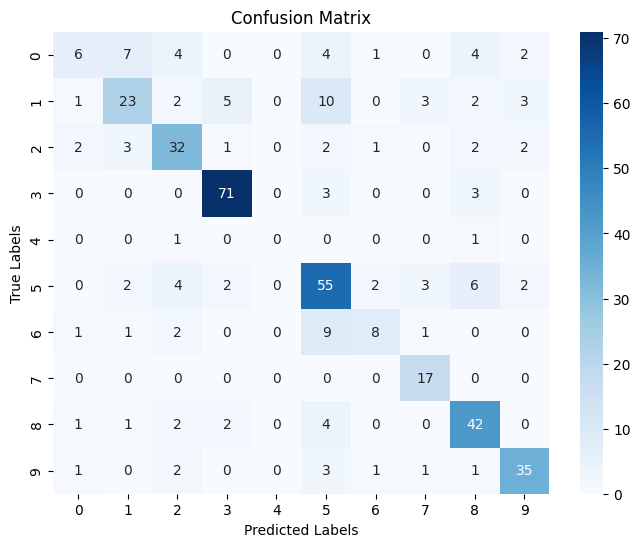

Accuracy: 0.7015


In [ ]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from transformers import Trainer
import numpy as np

# Step 1: Make predictions on the test dataset
predictions = trainer.predict(test_dataset)

# Get predicted labels (logits -> class predictions)
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), dim=-1)

# Get true labels from the test dataset
true_labels = torch.tensor(test_dataset["labels"])

# Step 2: Print detailed classification report (Accuracy, Precision, Recall, F1)
print("Classification Report:")
print(classification_report(true_labels.numpy(), predicted_labels.numpy()))  # Adjust class names as needed

# Step 3: Plot the confusion matrix
cm = confusion_matrix(true_labels.numpy(), predicted_labels.numpy())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Step 4: Optional - Accuracy Calculation
accuracy = (predicted_labels == true_labels).float().mean()
print(f"Accuracy: {accuracy:.4f}")


In [ ]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from transformers import Trainer
import numpy as np

# Step 1: Make predictions on the test dataset
predictions = trainer.predict(tokenized_test_dataset)

# Get predicted labels (logits -> class predictions)
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), dim=-1)

# Get true labels from the test dataset
true_labels = torch.tensor(tokenized_test_dataset["labels"])

# Step 2: Print detailed classification report (Accuracy, Precision, Recall, F1)
print("Classification Report:")
print(classification_report(true_labels.numpy(), predicted_labels.numpy()))  # Adjust class names as needed


Classification Report:
              precision    recall  f1-score   support

           0       0.07      0.02      0.03        95
           1       0.20      0.15      0.17       160
           2       0.24      0.22      0.23       149
           3       0.41      0.52      0.46       253
           4       0.00      0.00      0.00         6
           5       0.31      0.49      0.38       248
           6       0.23      0.09      0.13        74
           7       0.25      0.02      0.03        56
           8       0.32      0.42      0.36       171
           9       0.29      0.19      0.23       146

    accuracy                           0.31      1358
   macro avg       0.23      0.21      0.20      1358
weighted avg       0.28      0.31      0.28      1358



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from transformers import AutoModelForSequenceClassification

# Load the model
model = AutoModelForSequenceClassification.from_pretrained("burakaytan/roberta-base-turkish-uncased")

# Print the model configuration
print(model.config.max_position_embeddings)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at burakaytan/roberta-base-turkish-uncased and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


514


In [ ]:
# Loop through the dataset and print the lengths of input_ids
for idx, example in enumerate(train_dataset):
    input_ids_length = len(example['input_ids'])

    # Print the index and length if it's not equal to 4096
    if input_ids_length != 4096:
        print(f"Example {idx} has a length of {input_ids_length} (not 4096)")


In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",                  # Directory to save model checkpoints
    eval_strategy="steps",                   # Evaluate every 'logging_steps'
    save_strategy="steps",                   # Save model checkpoints every 'logging_steps'
    logging_steps=10,                        # Log every 10 steps
    num_train_epochs=8,                      # Number of epochs
    per_device_train_batch_size=16,          # Batch size for training
    per_device_eval_batch_size=16,           # Batch size for evaluation
    weight_decay=0.01,                       # Regularization
    load_best_model_at_end=True,             # Load the best model at the end of training
    metric_for_best_model="eval_accuracy",  # Metric to determine best model
    evaluation_strategy="steps",             # Evaluate model after each logging step
    eval_steps=50,                          # Evaluate every 100 steps
    logging_dir="./logs",                    # Directory for logs
    report_to="wandb",                       # Report to W&B
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics  # Pass the compute_metrics function
)

trainer.train()



/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
50,0.194900,2.630970,0.632603
100,0.166000,2.184589,0.639903
150,0.091900,2.582901,0.647202
200,0.127800,2.497170,0.644769
250,0.052600,2.643814,0.627737
300,0.041800,2.591111,0.659367


In [ ]:
trainer.evaluate()

{'eval_accuracy': 0.6399026763990268,
 'eval_loss': 1.8917242288589478,
 'eval_runtime': 11.4151,
 'eval_samples_per_second': 36.005,
 'eval_steps_per_second': 2.278,
 'epoch': 5.0}

In [ ]:
print(train_dataset.column_names)


['text', 'label', '__index_level_0__']


In [ ]:
from pickle import TUPLE
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def preprocess_text(text):
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-ZçÇğĞıİöÖşŞüÜ\s]', '', text)

    # Convert text to lowercase
    text = text.casefold()

    # Remove stop words (if necessary)
    words = text.split()
    words = [word for word in words if word not in turkish_stopwords]
    words = [word for word in words if word not in ENGLISH_STOP_WORDS]
    # Rejoin the words into a cleaned text string
    return ' '.join(words)

train_profile_df['biography'] = train_profile_df['biography'].apply(preprocess_text)
# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=100)  # You can adjust the max_features as needed

# Fit and transform the 'biography' column to get the TF-IDF matrix
X_tfidf = vectorizer.fit_transform(train_profile_df['biography'])

# Binarize the TF-IDF matrix (convert all non-zero values to 1)
X_binary = (X_tfidf > 0).astype(int)

# Convert the sparse matrix to a dense matrix and store each row as a list
train_profile_df['biography_vector'] = list(X_binary.toarray())

# Display the DataFrame with the new 'biography_vector' column
print(train_profile_df[['biography', 'biography_vector']].head())

                                           biography  \
0              mediaplanning mediabuying sosyalmedya   
1  sogutozuftz avm ankara macrocenter migroslarda...   
2         dijital i̇letişim yönetimiinfovimerangcomq   
3                             talas belediye baskanı   
4  türkiyenin ilindeki yaygın elektrikli şarj ist...   

                                    biography_vector  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  


In [ ]:
train_profile_df["biography_vector"][0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
train_profile_df.dtypes

,0
username,object
full_name,object
biography,object
category_name,int64
follower_count,int64
following_count,int64
is_business_account,bool
is_private,bool
is_verified,bool
highlight_reel_count,int64


In [ ]:
biography_vector_df = pd.DataFrame(train_profile_df['biography_vector'].to_list(), columns=[f'biography_{i}' for i in range(100)])

In [ ]:
biography_vector_df


,biography_0,biography_1,biography_2,biography_3,biography_4,biography_5,biography_6,biography_7,biography_8,biography_9,...,biography_90,biography_91,biography_92,biography_93,biography_94,biography_95,biography_96,biography_97,biography_98,biography_99
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2736,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2737,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2738,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2739,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X = pd.concat([X, biography_vector_df], axis=1)

NameError: name 'X' is not defined

In [ ]:
X

,follower_count,following_count,is_business_account,is_private,is_verified,highlight_reel_count,country_block,has_clips,hide_like_and_view_counts,is_professional_account,...,biography_90,biography_91,biography_92,biography_93,biography_94,biography_95,biography_96,biography_97,biography_98,biography_99
0,1167,192,1,0,0,6,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,11997,17,1,0,0,15,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,2321,454,1,0,0,11,0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,13647,29,1,0,1,2,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,7917,11,1,0,1,7,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2736,9259,968,1,0,0,6,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2737,1149,894,1,0,0,5,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.578708,0.0
2738,1065,10,1,0,0,10,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2739,1379,63,1,0,0,24,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


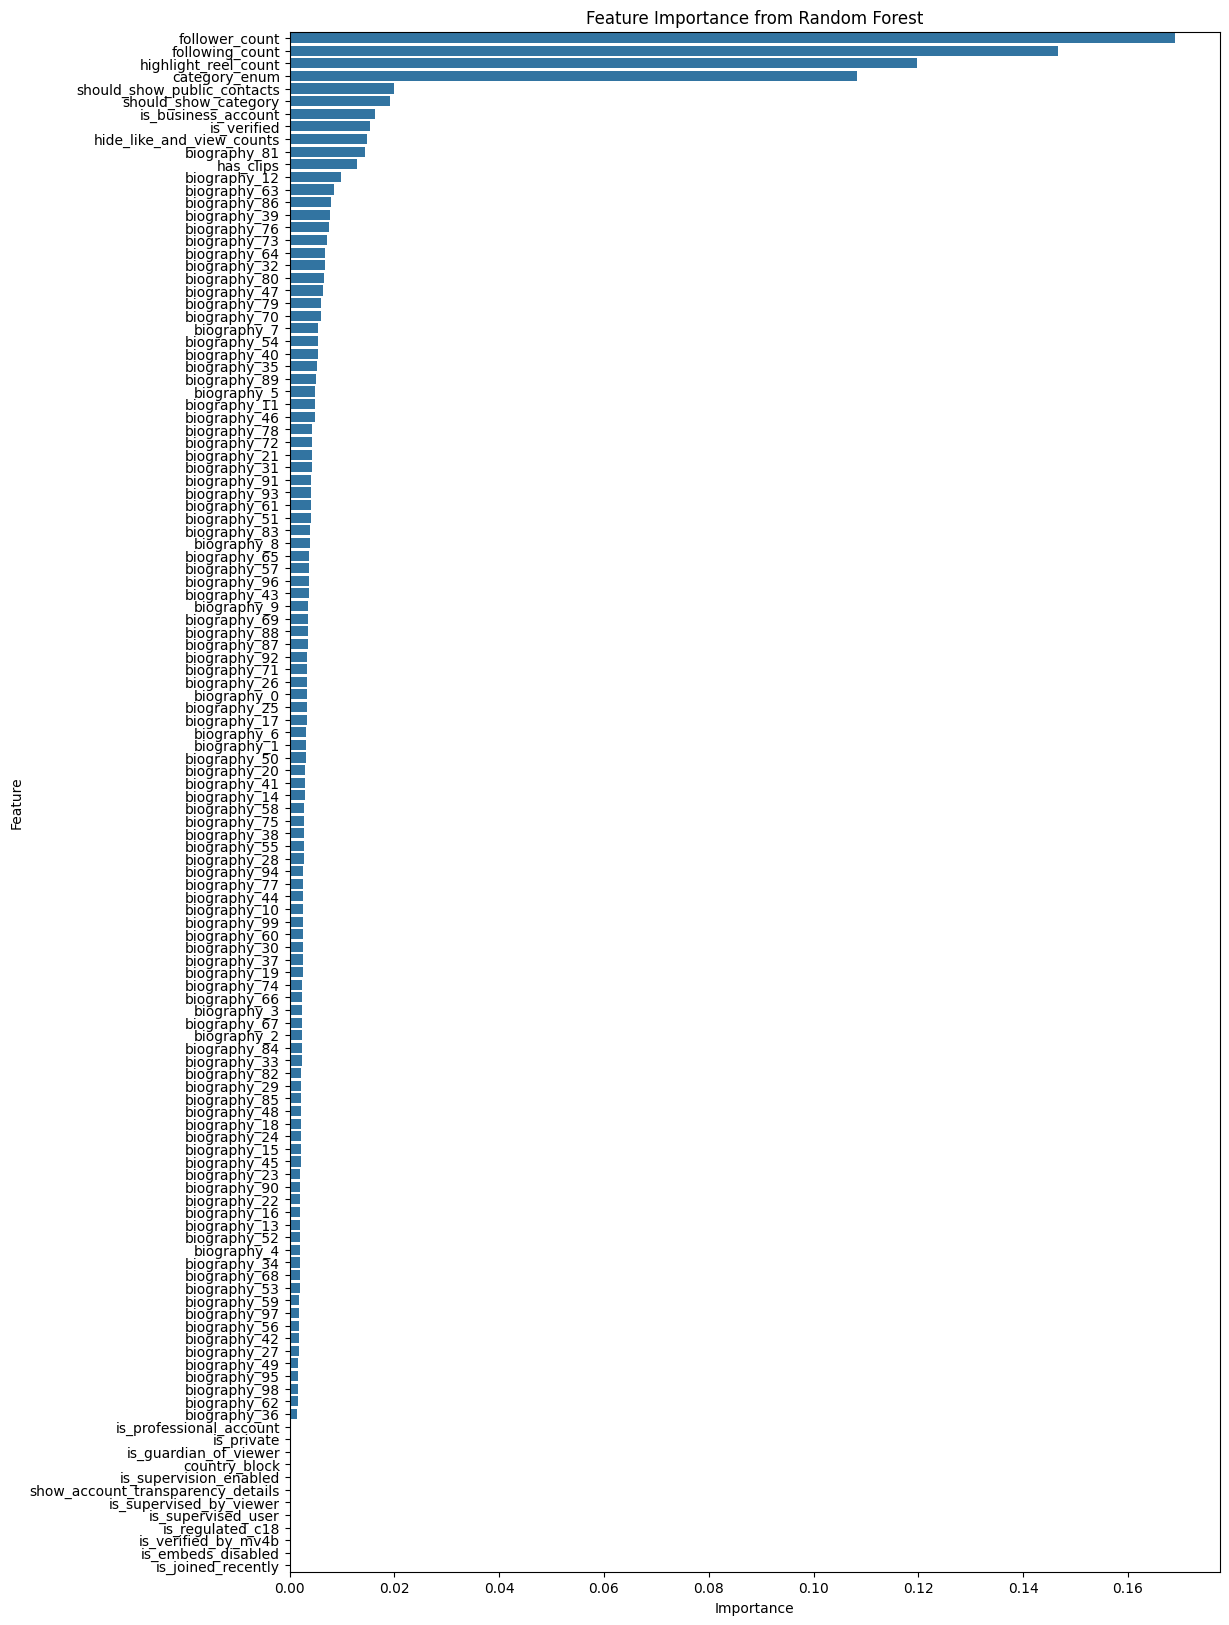

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Prepare the features (X) and target variable (y)
# Drop 'category', 'username', 'full_name', 'category_name', 'biography', 'external_url'
# 'biography_vector' will be added later, so we exclude it from the initial X
X = train_profile_df.drop(columns=['category', 'username', 'full_name', 'category_name', 'biography', 'external_url','biography_vector'])

# Add the 'biography_vector' into the feature set (this is a list of numerical values, so we need to flatten it)
# Ensure 'biography_vector' is a list of arrays, then expand it into multiple columns
biography_vector_df = pd.DataFrame(train_profile_df['biography_vector'].to_list(), columns=[f'biography_{i}' for i in range(100)])

# Combine the original features with the 'biography_vector'
X = pd.concat([X, biography_vector_df], axis=1)

# 'category' is the target variable
y = train_profile_df['category'].dropna()  # Drop any NaN values from the target column

# Step 2: Train the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Step 3: Extract feature importances
importances = rf.feature_importances_

# Step 4: Create a DataFrame to hold feature importances
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Step 5: Visualize the feature importances
plt.figure(figsize=(12, 20))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

# Step 1: Prepare the features (X) and target variable (y)
X = train_profile_df.drop(columns=['category', 'username', 'full_name', 'category_name', 'biography', 'external_url', 'biography_vector'])

# Step 2: Add the 'biography_vector' into the feature set (this is a list of numerical values, so we need to flatten it)
biography_vector_df = pd.DataFrame(train_profile_df['biography_vector'].to_list(), columns=[f'biography_{i}' for i in range(100)])
X = pd.concat([X, biography_vector_df], axis=1)

# 'category' is the target variable
y = train_profile_df['category'].dropna()  # Drop any NaN values from the target column

# Step 3: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Feature Scaling (important for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Train the SVM model with default parameters
svm = SVC(random_state=42)  # Using the default parameters
svm.fit(X_train_scaled, y_train)

# Step 6: Predict on the test set
y_pred = svm.predict(X_test_scaled)

# Step 7: Evaluate the model
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy Score: 0.3005464480874317

Classification Report:
                      precision    recall  f1-score   support

                 art       0.33      0.03      0.05        38
       entertainment       0.21      0.32      0.26        59
             fashion       0.19      0.11      0.14        55
                food       0.33      0.62      0.43       114
              gaming       0.00      0.00      0.00         5
health and lifestyle       0.27      0.41      0.33        96
    mom and children       0.40      0.06      0.10        34
              sports       0.75      0.11      0.19        27
                tech       0.30      0.19      0.23        59
              travel       0.68      0.21      0.32        62

            accuracy                           0.30       549
           macro avg       0.35      0.21      0.20       549
        weighted avg       0.35      0.30      0.27       549



c:\Users\husey\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\husey\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\husey\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

# Step 1: Prepare the features (X) and target variable (y)
X = train_profile_df.drop(columns=['category', 'username', 'full_name', 'category_name', 'biography', 'external_url', 'biography_vector'])

# Step 2: Add the 'biography_vector' into the feature set (this is a list of numerical values, so we need to flatten it)
biography_vector_df = pd.DataFrame(train_profile_df['biography_vector'].to_list(), columns=[f'biography_{i}' for i in range(100)])
X = pd.concat([X, biography_vector_df], axis=1)

# 'category' is the target variable
y = train_profile_df['category'].dropna()  # Drop any NaN values from the target column

# Step 3: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Feature Scaling (important for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Hyperparameter tuning using GridSearchCV
# We will tune the C, kernel, and gamma parameters for the SVM classifier.
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto', 0.1, 1]
}



grid_search = GridSearchCV(SVC(), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Step 6: Best parameters from GridSearchCV
print("Best Parameters from GridSearchCV:", grid_search.best_params_)

# Step 7: Train the SVM model with the best parameters
best_svm = grid_search.best_estimator_
best_svm.fit(X_train_scaled, y_train)

# Step 8: Predict on the test set
y_pred = best_svm.predict(X_test_scaled)

# Step 9: Evaluate the model
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Best Parameters from GridSearchCV: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy Score: 0.30965391621129323

Classification Report:
                      precision    recall  f1-score   support

                 art       0.50      0.05      0.10        38
       entertainment       0.21      0.32      0.25        59
             fashion       0.23      0.15      0.18        55
                food       0.33      0.63      0.43       114
              gaming       0.00      0.00      0.00         5
health and lifestyle       0.28      0.41      0.33        96
    mom and children       0.40      0.06      0.10        34
              sports       0.75      0.11      0.19        27
                tech       0.33      0.20      0.25        59
              travel       0.72      0.21      0.33        62

            accuracy                           0.31       549
           macro avg       0.38      0.21      0.22       549
        weighted avg       0.38      0.31      0.28   

c:\Users\husey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\husey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\husey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [ ]:
import ast
import pandas as pd

# Step 1: Check the 'biography_vector' column for problematic entries
train_profile_df['biography_vector'].head()

# Step 2: Replace any null values or strings with empty lists (or another default)
train_profile_df['biography_vector'] = train_profile_df['biography_vector'].fillna("[]")

# Step 3: Safely convert the string representation of lists into actual lists using ast.literal_eval
train_profile_df['biography_vector'] = train_profile_df['biography_vector'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Step 4: If the column is already in list form, you can split it into individual columns if needed
# Example: If 'biography_vector' is a list of numbers, you can expand it into new columns
biography_vector_df = pd.DataFrame(train_profile_df['biography_vector'].tolist())

# Optional: Combine the vectorized features with the rest of the DataFrame
X = pd.concat([train_profile_df.drop(columns=['biography_vector']), biography_vector_df], axis=1)

# Check the result
X.head()


,username,full_name,biography,category_name,follower_count,following_count,is_business_account,is_private,is_verified,highlight_reel_count,...,90,91,92,93,94,95,96,97,98,99
0,deparmedya,Depar Medya,mediaplanning mediabuying sosyalmedya,185,1167,192,True,False,False,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,kafesfirin,KAFES FIRIN,sogutozuftz avm ankara macrocenter migroslarda...,42,11997,17,True,False,False,15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,vimerang,Vimerang,dijital iletişim yönetimiinfovimerangcomq,333,2321,454,True,False,False,11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,mustafa_yalcinn38,Mustafa Yalçın,talas belediye baskanı,244,13647,29,True,False,True,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,zorluenergysolutions,ZES (Zorlu Energy Solutions),türkiyenin ilindeki yaygın elektrikli şarj ist...,333,7917,11,True,False,True,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
test_profile_df.head(2)

,username,id,full_name,biography,category_name,post_count,follower_count,following_count,is_business_account,is_private,...,business_category_name,overall_category_name,category_enum,is_verified_by_mv4b,is_regulated_c18,profile_pic_url,should_show_category,should_show_public_contacts,show_account_transparency_details,profile_picture_base64
0,beyazyakaliyiz,8634457436,Selam Beyaz Yakalı,Beyaz yakalıların dünyasına hoşgeldiniz 😀😀😀,Personal blog,None,1265,665,True,False,...,None,None,PERSONAL_BLOG,False,False,https://instagram.fist6-1.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
1,totalenergies_istasyonlari,7066643793,TotalEnergies İstasyonları,TotalEnergies İstasyonları resmi Instagram hes...,Energy Company,None,28025,4,True,False,...,None,None,ENERGY_COMPANY,False,False,https://instagram.fsaw2-1.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...


In [ ]:
train_profile_df["business_contact_method"]

KeyError: 'business_contact_method'

In [ ]:
with pd.option_context('display.max_columns', None):
    print(train_profile_df.head())


               username          id                     full_name  \
0            deparmedya  3170700063                   Depar Medya   
1            kafesfirin   266439571                   KAFES FIRIN   
2              vimerang  2367195567                      Vimerang   
3     mustafa_yalcinn38  9606564254               Mustafa Yalçın   
4  zorluenergysolutions  8155780357  ZES (Zorlu Energy Solutions)   

                                           biography   category_name  \
0           #mediaplanning #mediabuying #sosyalmedya  Local business   
1  📍Söğütözü📍FTZ AVM\n🛒Ankara macro▲center v...           Brand   
2       Dijital İletişim Yönetimi🎬info@vimerang.comq            None   
3                            Talas Belediye Başkanı      Politician   
4  Türkiye’nin 81 ilindeki en yaygın elektrikli ş...            None   

  follower_count following_count is_business_account is_private is_verified  \
0           1167             192                True      False       Fal

In [ ]:
train_profile_df.dtypes

username                             object
id                                   object
full_name                            object
biography                            object
category_name                        object
follower_count                       object
following_count                      object
is_business_account                  object
is_private                           object
is_verified                          object
highlight_reel_count                 object
bio_links                            object
entities                             object
country_block                        object
eimu_id                              object
external_url                         object
fbid                                 object
has_clips                            object
hide_like_and_view_counts            object
is_professional_account              object
is_supervision_enabled               object
is_guardian_of_viewer                object
is_supervised_by_viewer         

#TF_IDF
words are not numbers, we should transform them to numerical values

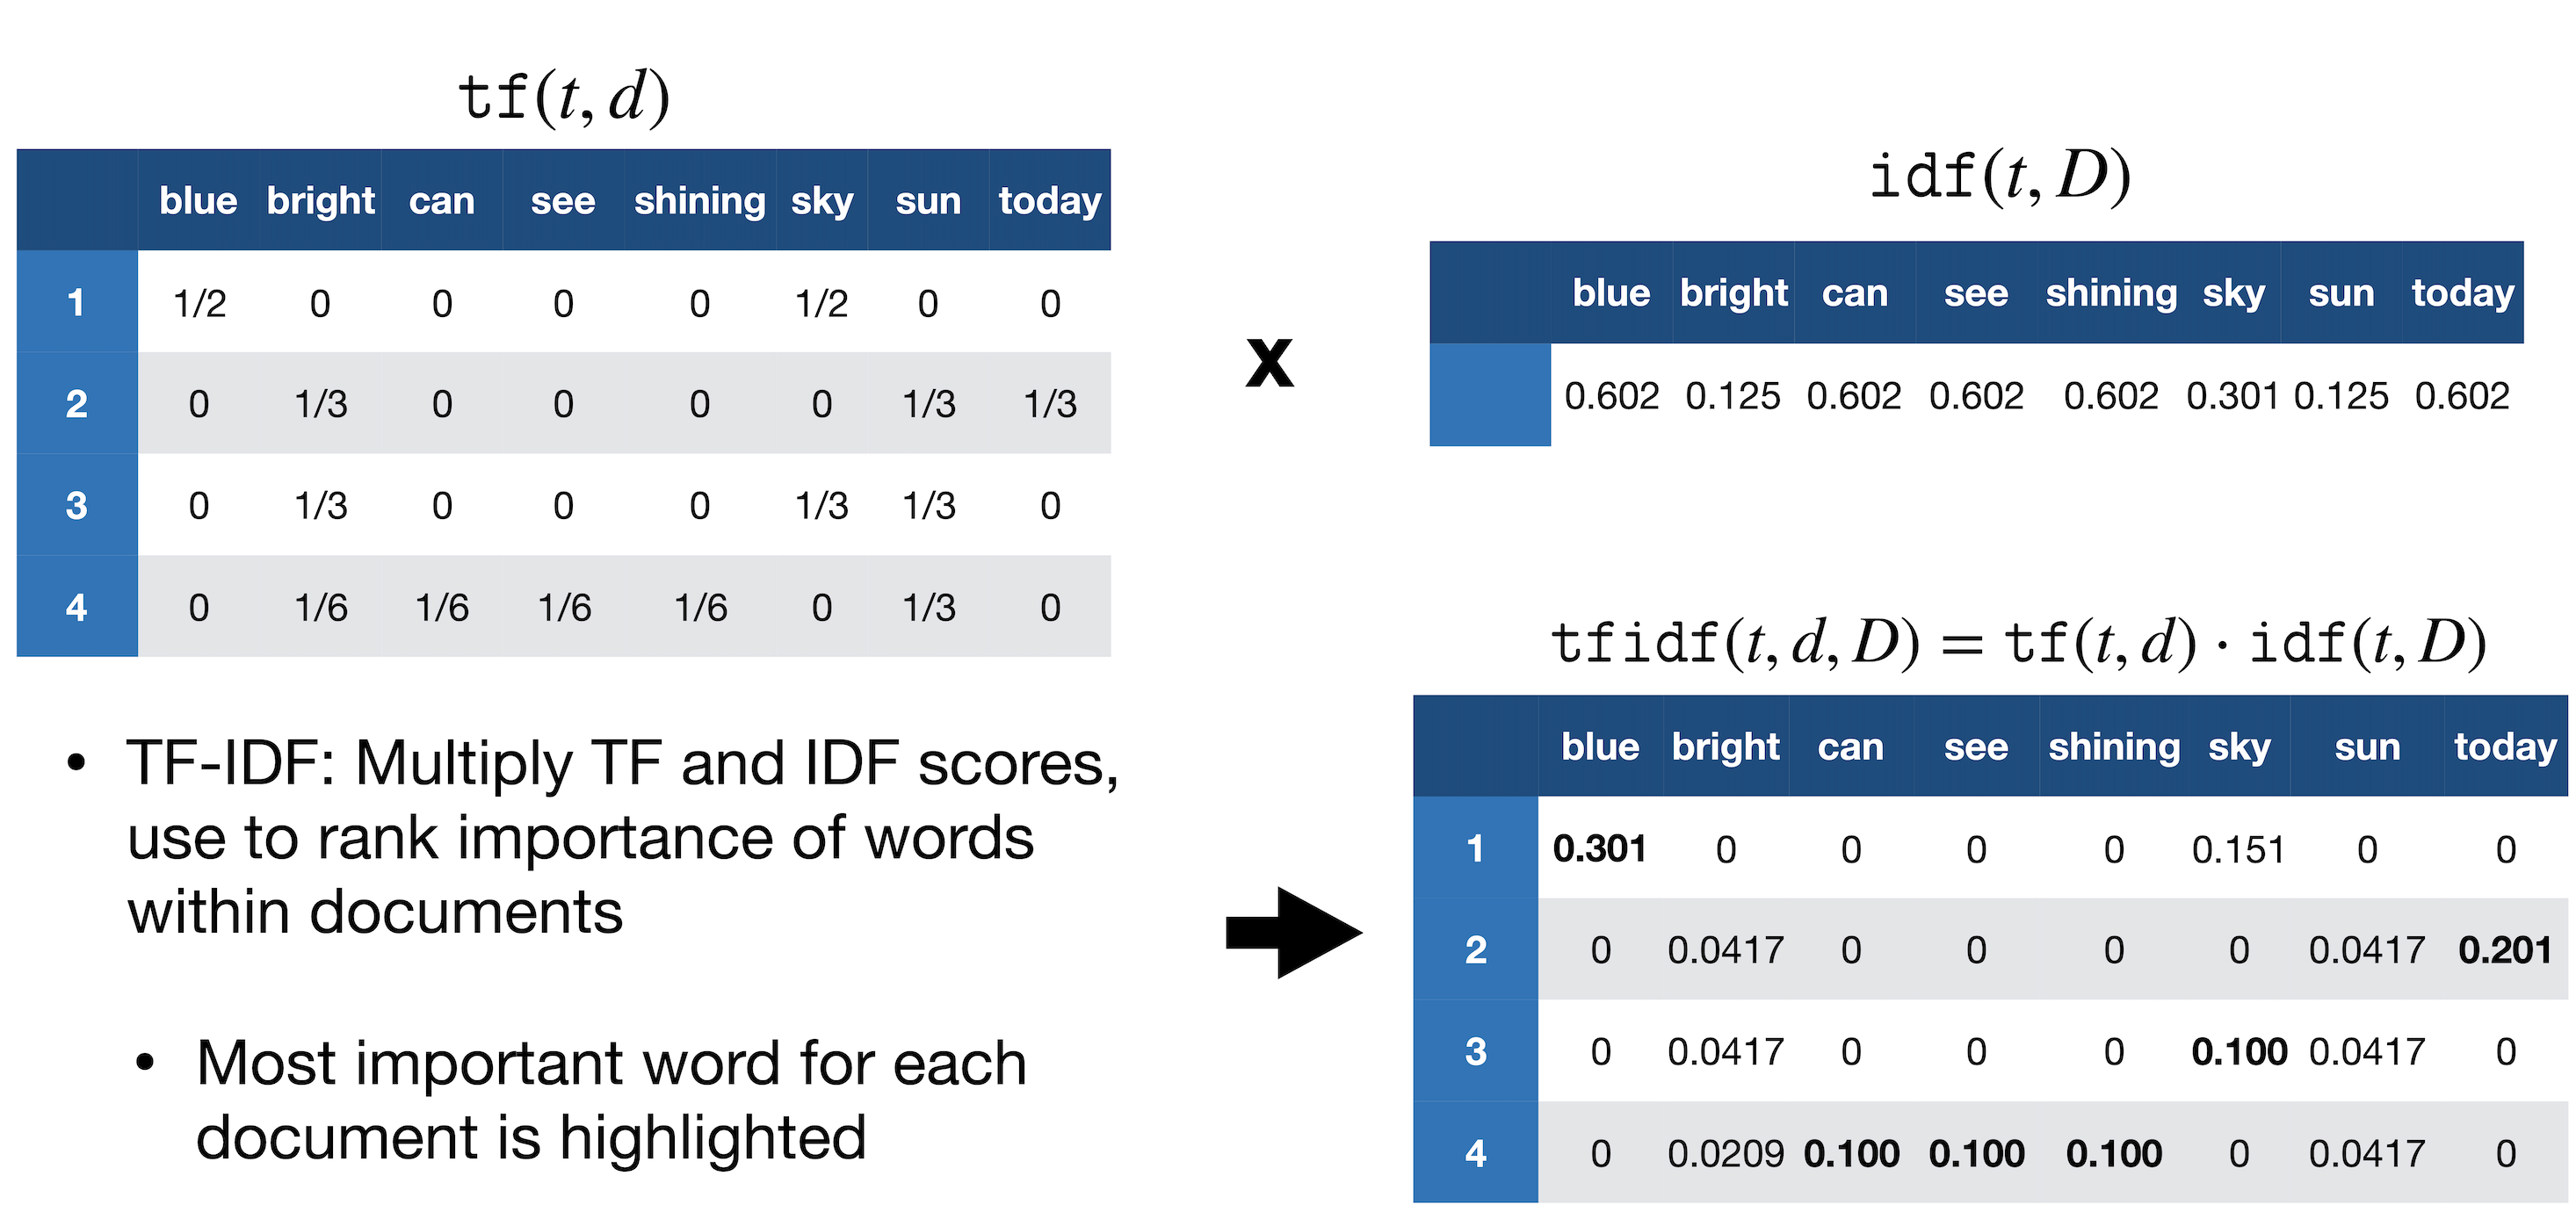

# Let's check the documentation of scikit-learn
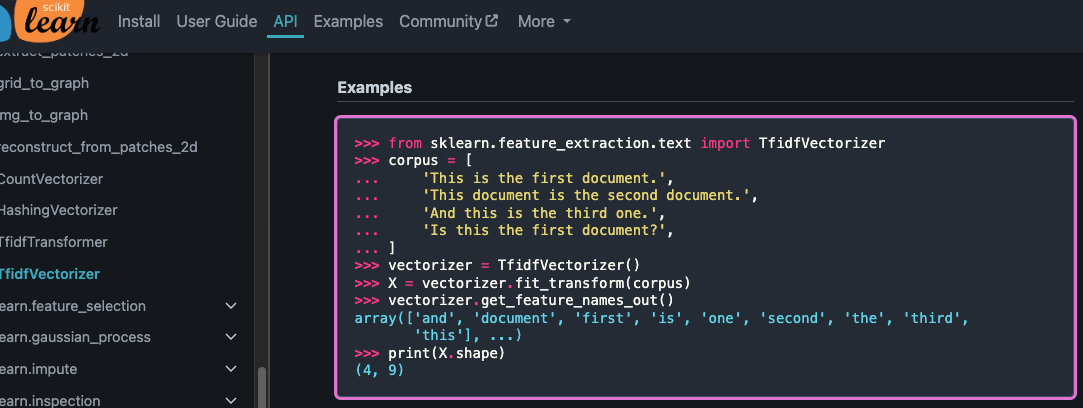

Here our corpus is all of our post data
so we should concat aggregate all of them and provide as a corpus to the Tf-IDF vectorizer of the scikit-learn.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import torch

In [ ]:
from torch import Tensor

In [ ]:
from transformers import BertTokenizer, BertForTokenClassification

# Load a pre-trained Turkish BERT model
model_name = 'dbmdz/bert-base-turkish-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForTokenClassification.from_pretrained(model_name)


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/251k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from torch import Tensor
print(Tensor)


<class 'torch.Tensor'>


In [ ]:
def preprocess_text(text: str):
    # Lower casing Turkish Text, avoiding str.lower
    text = text.casefold()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove special characters and punctuation
    text = re.sub(r'[^a-zçğıöşü0-9\s#@]', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

   # Tokenize the text
    tokens = tokenizer.tokenize(tokenizer.decode(tokenizer.encode(text)))

    # Load stopwords for the specified language

    # Filter out stopwords
    filtered_text = [w for w in tokens if w.lower() not in turkish_stopwords]

    if len(filtered_text) > 512:
        filtered_text = filtered_text[:512]

    # Return the text as a sentence
    return " ".join(filtered_text)

In [ ]:
from nltk.tokenize import word_tokenize

In [ ]:
import nltk
nltk.download('punkt')  # Make sure this is done
nltk.download('stopwords')  # Ensure stopwords are available

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:

# Example text
text = "Merhaba, nasılsın? Bugün hava çok güzel."

# Tokenize the text
tokens = tokenizer.tokenize(tokenizer.decode(tokenizer.encode(text)))
print(tokens)


['[CLS]', 'Merhaba', ',', 'nasıl', '##sın', '?', 'Bugün', 'hava', 'çok', 'güzel', '.', '[SEP]']


In [ ]:
import pandas as pd

# Initialize lists to store usernames and aggregated posts
train_usernames = []
corpus = []
for username, posts in username2posts_train.items():
    train_usernames.append(username)  # Keep track of usernames

    # Aggregate posts per user
    cleaned_captions = []
    for post in posts:
        post_caption = post.get("caption", "")
        if post_caption is None:
            continue

        # Preprocess the text (e.g., remove stopwords, tokenize, etc.)
        post_caption = preprocess_text(post_caption)
        if post_caption != "":
            cleaned_captions.append(post_caption)

    # Join the posts of each user
    user_post_captions = "\n".join(cleaned_captions)
    corpus.append(user_post_captions)

# Create a DataFrame with username and posts columns
data = pd.DataFrame({
    "username": train_usernames,
    "posts": corpus
})

# Display the DataFrame
print(data)



Token indices sequence length is longer than the specified maximum sequence length for this model (566 > 512). Running this sequence through the model will result in indexing errors


                   username                                              posts
0                deparmedya  [CLS] cumhuriyet ##imizin yılı kutlu olsun [SE...
1                kafesfirin  [CLS] bugün bir fincan köpük ##lü türk kahve #...
2                  vimerang  [CLS] saygı özlem ##le # atatürk # kasım # kas...
3         mustafa_yalcinn38  [CLS] altın ##oluk çevre şehir ##cilik iklim d...
4      zorluenergysolutions  [CLS] güne enerji ##k bir sohbet devam etmek i...
...                     ...                                                ...
2736    tatlidunyasidergisi  [CLS] emel ##ay ##din ##bu ##tik ##pas ##ta ##...
2737  yerindengelsin.com.tr  [CLS] # ber ##line ##r # alman ##ek ##me ##ği ...
2738       woodtechistanbul  [CLS] söyledikleri ##m hakikat olduğu gün send...
2739               netsvadi  [CLS] net ##s vad ##ide nefes kamp ##i ara ##l...
2740          herbisiatolye  [CLS] gur ##d ##ji ##eff kutsal dans ##ları öğ...

[2741 rows x 2 columns]


In [ ]:
# Adding a category column based on username2_category
data['category'] = [
    username2_category.get(uname, "NA") for uname in data['username']
]


In [ ]:
data['label'] = data['category'].factorize()[0]
data.head()

,username,posts,category,label
0,deparmedya,[CLS] cumhuriyet ##imizin yılı kutlu olsun [SE...,tech,0
1,kafesfirin,[CLS] bugün bir fincan köpük ##lü türk kahve #...,food,1
2,vimerang,[CLS] saygı özlem ##le # atatürk # kasım # kas...,tech,0
3,mustafa_yalcinn38,[CLS] altın ##oluk çevre şehir ##cilik iklim d...,health and lifestyle,2
4,zorluenergysolutions,[CLS] güne enerji ##k bir sohbet devam etmek i...,tech,0


In [ ]:
import tensorflow as tf
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification
from sklearn.metrics import classification_report

In [ ]:
# Split the dataset into training and testing data
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
# Tokenize the data
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
train_encodings = tokenizer(train_df.posts.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_df.posts.tolist(), truncation=True, padding=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
# Create input pipelines
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_df.label))
train_dataset = train_dataset.shuffle(len(train_df)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_df.label))
test_dataset = test_dataset.batch(32)

In [ ]:
# Define the model
num_labels = len(train_df.label.unique())
model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=num_labels)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
# Train the model
from tensorflow import optimizers, losses, metrics
model.compile(
    optimizer=optimizers.Adam(learning_rate=5e-5),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=metrics.SparseCategoricalAccuracy()
)

In [ ]:
model.fit(train_dataset, epochs=5)

Epoch 1/5



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re

def preprocess_text(text: str):
    # Lower casing Turkish Text, avoiding str.lower
    text = text.casefold()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove special characters and punctuation
    text = re.sub(r'[^a-zçğıöşü0-9\s#@]', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text


# Prepare training data
train_usernames = []
corpus = []

for username, posts in username2posts_train.items():
    train_usernames.append(username)  # Keep track of usernames

    # Aggregate posts per user
    cleaned_captions = []
    for post in posts:
        post_caption = post.get("caption", "")
        if post_caption is None:
            continue

        post_caption = preprocess_text(post_caption)
        if post_caption != "":
            cleaned_captions.append(post_caption)

    # Join the posts of each user
    user_post_captions = "\n".join(cleaned_captions)
    corpus.append(user_post_captions)





# Map usernames to their categories
y_train = [username2_category.get(username, "NA") for username in train_usernames]

# Prepare test data
test_usernames = []
test_corpus = []

for username, posts in username2posts_test.items():
    test_usernames.append(username)  # Keep track of usernames

    # Aggregate posts per user
    cleaned_captions = []
    for post in posts:
        post_caption = post.get("caption", "")
        if post_caption is None:
            continue

        post_caption = preprocess_text(post_caption)
        if post_caption != "":
            cleaned_captions.append(post_caption)

    # Join the posts of each user
    user_post_captions = "\n".join(cleaned_captions)
    test_corpus.append(user_post_captions)


# Map test usernames to their categories
y_test = [username2_category.get(username, "NA") for username in test_usernames]

# Combine data with usernames
train_data = {
    "username": train_usernames,
    "features": corpus,
    "labels": y_train
}

test_data = {
    "username": test_usernames,
    "features": test_corpus,
    "labels": y_test
}

import pandas as pd

# Convert the train data dictionary to a DataFrame
train_df = pd.DataFrame(train_data)

# Convert the test data dictionary to a DataFrame
test_df = pd.DataFrame(test_data)

# Display the first few rows of the train and test DataFrames
print("Sample Training Data (DataFrame):")
print(train_df.head())

print("Sample Test Data (DataFrame):")
print(test_df.head())
train_df["features"]


Sample Training Data:
Username: deparmedya
Label: tech,cumhuriyetimizin yılı kutlu olsun
oriflame duologi lansmanı #isveçtengelengüzellik #oriflameilesaçbakımdevrimi
#oriflameilesaçbakımdevrimi
#oriflameilesaçbakımdevrimi agustos oriflameturkiye
agustos #oriflameturkiye #duoloji
oriflame #duoloji
muhteşem saçların sırrı #duoloji oriflameturkiye
goe elektirikli motorsiklet ile sürdürülebilir bir yaşamın elçisi olun#goeilegeleceğeyönver #goeilesürdürülebilirgelecek #easytorideeasytolove goemobility
haziran #yazamerhaba feridaistanbul
haziran #yazamerhaba
feridaistanbul #yazamerhaba feridacadde
jumbopatisserienin edible art konseptiyle özel olarak hazırlanan tatlıları ve baci milanonun şık ve renkli dünyasında kahvaltıdayız#jumboturkiye
easy to love easy to ride goemobility
figamortr
mustafa kemal atatürkü sevgisaygı ve özlemle anıyoruz
notecosmetiqueturkiye #event #kendimenote
notecosmetiqueturkiye
otoshops outdoor çalışmaları otoshopsturkiye
mad parfüm outdoor çalışmalarımız madparfumeu

Sample Training Data (DataFrame):
               username                                           features  \
0            deparmedya  cumhuriyetimizin yılı kutlu olsun\noriflame du...   
1            kafesfirin  bugün bir fincan köpüklü türk kahvesiyle taçla...   
2              vimerang  saygı ve özlemle #atatürk #kasım #kasim #vimer...   
3     mustafa_yalcinn38  altınoluk çevre şehircilik ve iklim değişikliğ...   
4  zorluenergysolutions  güne enerjik bir sohbet ile devam etmek ister ...   

                 labels  
0                  tech  
1                  food  
2                  tech  
3  health and lifestyle  
4                  tech  
Sample Test Data (DataFrame):
                     username  \
0              beyazyakaliyiz   
1  totalenergies_istasyonlari   
2                 konforyatak   
3                    ht_kulup   
4                   ajansspor   

                                            features labels  
0  bu diyaloğun yaşanmadığı bir online toplantı o.

,features
0,cumhuriyetimizin yılı kutlu olsun\noriflame du...
1,bugün bir fincan köpüklü türk kahvesiyle taçla...
2,saygı ve özlemle #atatürk #kasım #kasim #vimer...
3,altınoluk çevre şehircilik ve iklim değişikliğ...
4,güne enerjik bir sohbet ile devam etmek ister ...
...,...
2736,emelaydinbutikpastacilik butikpastacilarderneg...
2737,#berliner #almanekmeği #hercumartesi\n#almanba...
2738,bu söylediklerim hakikat olduğu gün senden ve ...
2739,nets vadide nefes kampi aralik az sayıda kişi ...


In [ ]:
import tensorflow as tf
print("GPU Devices:", tf.config.list_physical_devices('GPU'))


GPU Devices: []


In [ ]:
import pandas as pd

# Convert the TF-IDF features into a DataFrame for easier merging
vector_df = pd.DataFrame(
    x_post_train.toarray(),  # Convert sparse matrix to dense
    index=train_usernames,  # Use usernames as the index
    columns=[f'feature_{i}' for i in range(x_post_train.shape[1])]  # Feature names
)

# Add the vectors as a single array column to `train_profile_df`
# First, create a column where each entry is a numpy array of the TF-IDF features
vector_df['tfidf_vector'] = vector_df.apply(lambda row: row.values, axis=1)

# Merge the vector column with `train_profile_df`
train_profile_df = train_profile_df.merge(
    vector_df[['tfidf_vector']],  # Only merge the tfidf_vector column
    left_on='username',  # Merge on the username column
    right_index=True,  # Use the index of vector_df as the right key
    how='left'  # Perform a left join to preserve all rows in train_profile_df
)

# Check the result
print(train_profile_df[['username', 'tfidf_vector']].head())


               username                                       tfidf_vector
0            deparmedya  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1            kafesfirin  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2              vimerang  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3     mustafa_yalcinn38  [0.047264336546735265, 0.0, 0.0, 0.0, 0.0, 0.0...
4  zorluenergysolutions  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...


In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Extend TF-IDF column into individual columns
tfidf_df = pd.DataFrame(
    train_profile_df['tfidf_vector'].to_list(),  # Assuming 'tfidf_vector' is the column name for TF-IDF vectors
    columns=[f'tfidf_{i}' for i in range(len(train_profile_df['tfidf_vector'][0]))]
)

# Step 2: Drop unnecessary columns and add the expanded TF-IDF features
X = train_profile_df.drop(columns=['category', 'username', 'full_name', 'category_name', 'biography', 'external_url', 'biography_vector', 'tfidf_vector'])

# Expand 'biography_vector' into multiple columns
biography_vector_df = pd.DataFrame(
    train_profile_df['biography_vector'].to_list(),
    columns=[f'biography_{i}' for i in range(len(train_profile_df['biography_vector'][0]))]
)

# Combine TF-IDF, biography vectors, and remaining features
X = pd.concat([X, biography_vector_df, tfidf_df], axis=1)

# Debugging: Ensure all columns in X are numeric
assert all(pd.api.types.is_numeric_dtype(X[col]) for col in X.columns), "Non-numeric data found in features!"

# Target variable
y = train_profile_df['category']

# Step 3: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Train SVM model
svm = SVC(random_state=42)
svm.fit(X_train_scaled, y_train)

# Step 6: Predictions
y_pred = svm.predict(X_test_scaled)

# Step 7: Evaluation
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy Score: 0.4918032786885246

Classification Report:
                      precision    recall  f1-score   support

                 art       1.00      0.03      0.05        38
       entertainment       0.44      0.27      0.34        59
             fashion       0.57      0.47      0.51        55
                food       0.85      0.73      0.78       114
              gaming       0.00      0.00      0.00         5
health and lifestyle       0.29      0.84      0.43        96
    mom and children       0.00      0.00      0.00        34
              sports       1.00      0.04      0.07        27
                tech       0.66      0.63      0.64        59
              travel       0.76      0.40      0.53        62

            accuracy                           0.49       549
           macro avg       0.56      0.34      0.34       549
        weighted avg       0.61      0.49      0.46       549



c:\Users\husey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\husey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\husey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Step 1: Extend TF-IDF column into individual columns
tfidf_df = pd.DataFrame(
    train_profile_df['tfidf_vector'].to_list(),
    columns=[f'tfidf_{i}' for i in range(len(train_profile_df['tfidf_vector'][0]))]
)

# Drop unnecessary columns and add the expanded TF-IDF features
X = train_profile_df.drop(columns=['category', 'username', 'full_name', 'category_name', 'biography', 'external_url', 'biography_vector', 'tfidf_vector'])

# Expand 'biography_vector' into multiple columns
biography_vector_df = pd.DataFrame(
    train_profile_df['biography_vector'].to_list(),
    columns=[f'biography_{i}' for i in range(len(train_profile_df['biography_vector'][0]))]
)

# Combine TF-IDF, biography vectors, and remaining features
X = pd.concat([X, biography_vector_df, tfidf_df], axis=1)

# Target variable
y = train_profile_df['category']

# Step 2: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Step 1: Encode string labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Convert string labels to integers

# Split the encoded labels
y_train, y_test = train_test_split(y_encoded, test_size=0.2, random_state=42)

# Step 2: Convert integer labels to one-hot encoding
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)
# Step 4: Define the MLP model
model = Sequential([
    Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dropout(0.3),  # Dropout for regularization
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train_categorical.shape[1], activation='softmax')  # Output layer with softmax
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 5: Train the model
history = model.fit(X_train_scaled, y_train_categorical, epochs=30, batch_size=32, validation_split=0.2, verbose=1)

# Step 6: Evaluate the model
y_pred = model.predict(X_test_scaled)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test_categorical, axis=1)

print("Accuracy Score:", accuracy_score(y_test_labels, y_pred_labels))
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred_labels))


Epoch 1/10


c:\Users\husey\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: Could not interpret metric identifier: F1-Score

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder

# Step 1: Extend TF-IDF column into individual columns
tfidf_df = pd.DataFrame(
    train_profile_df['tfidf_vector'].to_list(),
    columns=[f'tfidf_{i}' for i in range(len(train_profile_df['tfidf_vector'][0]))]
)

# Drop unnecessary columns and add the expanded TF-IDF features
X = train_profile_df.drop(columns=['category', 'username', 'full_name', 'category_name', 'biography', 'external_url', 'biography_vector', 'tfidf_vector'])

# Expand 'biography_vector' into multiple columns
biography_vector_df = pd.DataFrame(
    train_profile_df['biography_vector'].to_list(),
    columns=[f'biography_{i}' for i in range(len(train_profile_df['biography_vector'][0]))]
)

# Combine TF-IDF, biography vectors, and remaining features
X = pd.concat([X, biography_vector_df, tfidf_df], axis=1)

# Target variable
y = train_profile_df['category']

# Step 2: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Encode string labels as integers (Label Encoding)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Convert string labels to integers
y_test_encoded = label_encoder.transform(y_test)  # Apply the same encoding to the test labels

# Step 5: Define and train the MLP model from scikit-learn
mlp = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, random_state=42)

# Train the model
mlp.fit(X_train_scaled, y_train_encoded)

# Step 6: Evaluate the model
y_pred = mlp.predict(X_test_scaled)

# Get accuracy score
accuracy = accuracy_score(y_test_encoded, y_pred)
print("Accuracy Score:", accuracy)

# Classification report (Precision, Recall, F1-Score)
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred))


NameError: name 'train_profile_df' is not defined

In [ ]:
from transformers import pipeline

captioner = pipeline("image-to-text", model="Salesforce/blip-image-captioning-base")
captioner("https://huggingface.co/datasets/Narsil/image_dummy/resolve/main/parrots.png")
## [{'generated_text': 'two birds are standing next to each other '}]


ModuleNotFoundError: No module named 'transformers'

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Initialize XGBClassifier
xgb_model = XGBClassifier()

# Train the model
xgb_model.fit(X_train_scaled, y_train_encoded)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluate the model
accuracy_xgb = accuracy_score(y_test_encoded, y_pred_xgb)
print("XGBoost Accuracy Score:", accuracy_xgb)


XGBoost Accuracy Score: 0.6120218579234973


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Step 1: Prepare the Features and Target
# Assuming you have already prepared your X and y
X = train_profile_df.drop(columns=['category', 'username', 'full_name', 'category_name', 'biography', 'external_url', 'biography_vector', 'tfidf_vector'])
# Expand 'biography_vector' into multiple columns
biography_vector_df = pd.DataFrame(train_profile_df['biography_vector'].to_list(), columns=[f'biography_{i}' for i in range(len(train_profile_df['biography_vector'][0]))])
# Expand 'tfidf_vector' into multiple columns
tfidf_df = pd.DataFrame(train_profile_df['tfidf_vector'].to_list(), columns=[f'tfidf_{i}' for i in range(len(train_profile_df['tfidf_vector'][0]))])
# Concatenate features
X = pd.concat([X, biography_vector_df, tfidf_df], axis=1)

# Target variable
y = train_profile_df['category']

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Feature Scaling (important for many models, but not strictly necessary for RandomForest)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Encode Labels (if needed for classification)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Step 5: Initialize the Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Step 6: Train the Random Forest Model
rf_model.fit(X_train_scaled, y_train_encoded)

# Step 7: Make Predictions
y_pred_rf = rf_model.predict(X_test_scaled)

# Step 8: Evaluate the Model
accuracy_rf = accuracy_score(y_test_encoded, y_pred_rf)
print("Random Forest Accuracy Score:", accuracy_rf)
print("\nRandom Forest Classification Report:")
print(classification_report(y_test_encoded, y_pred_rf, target_names=label_encoder.classes_))


Random Forest Accuracy Score: 0.5919854280510018

Random Forest Classification Report:
                      precision    recall  f1-score   support

                 art       0.29      0.05      0.09        38
       entertainment       0.37      0.44      0.40        59
             fashion       0.59      0.76      0.67        55
                food       0.76      0.93      0.84       114
              gaming       0.00      0.00      0.00         5
health and lifestyle       0.48      0.65      0.55        96
    mom and children       0.50      0.03      0.06        34
              sports       1.00      0.11      0.20        27
                tech       0.62      0.83      0.71        59
              travel       0.69      0.55      0.61        62

            accuracy                           0.59       549
           macro avg       0.53      0.44      0.41       549
        weighted avg       0.59      0.59      0.55       549



c:\Users\husey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\husey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\husey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None,  20, 30],
    'min_samples_split': [2, 5, 10]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=3,
                           n_jobs=-1,
                           verbose=2)

grid_search.fit(X_train_scaled, y_train_encoded)

# Get the best hyperparameters and model
best_rf_model = grid_search.best_estimator_

# Evaluate the model
y_pred_rf_best = best_rf_model.predict(X_test_scaled)
accuracy_rf_best = accuracy_score(y_test_encoded, y_pred_rf_best)
print("Optimized Random Forest Accuracy Score:", accuracy_rf_best)
print("\nOptimized Random Forest Classification Report:")
print(classification_report(y_test_encoded, y_pred_rf_best, target_names=label_encoder.classes_))

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Optimized Random Forest Accuracy Score: 0.599271402550091

Optimized Random Forest Classification Report:
                      precision    recall  f1-score   support

                 art       0.20      0.03      0.05        38
       entertainment       0.36      0.41      0.38        59
             fashion       0.61      0.75      0.67        55
                food       0.75      0.94      0.84       114
              gaming       0.00      0.00      0.00         5
health and lifestyle       0.49      0.69      0.57        96
    mom and children       0.67      0.06      0.11        34
              sports       1.00      0.11      0.20        27
                tech       0.64      0.83      0.72        59
              travel       0.72      0.58      0.64        62

            accuracy                           0.60       549
           macro avg       0.54      0.44      0.42       549
        weighted avg     

c:\Users\husey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\husey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\husey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re

def preprocess_text(text: str):
    # lower casing Turkish Text, Don't use str.lower :)
    text = text.casefold()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove special characters and punctuation
    # HERE THE EMOJIS stuff are being removed, you may want to keep them :D
    text = re.sub(r'[^a-zçğıöşü0-9\s#@]', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text


corpus = []

# to keep the label order
train_usernames = []


for username, posts in username2posts_train.items():
  train_usernames.append(username)

  # aggregating the posts per user
  cleaned_captions = []
  for post in posts:
    post_caption = post.get("caption", "")
    if post_caption is None:
      continue

    post_caption = preprocess_text(post_caption)

    if post_caption != "":
      cleaned_captions.append(post_caption)


  # joining the posts of each user with a \n
  user_post_captions = "\n".join(cleaned_captions)
  corpus.append(user_post_captions)


vectorizer = TfidfVectorizer(stop_words=turkish_stopwords, max_features=5000)

# fit the vectorizer
vectorizer.fit(corpus)


# transform the data into vectors
x_post_train = vectorizer.transform(corpus)
y_train = [username2_category.get(uname, "NA") for uname in train_usernames]


test_usernames = []
test_corpus = []
for username, posts in username2posts_test.items():
  test_usernames.append(username)
  # aggregating the posts per user
  cleaned_captions = []
  for post in posts:
    post_caption = post.get("caption", "")
    if post_caption is None:
      continue

    post_caption = preprocess_text(post_caption)

    if post_caption != "":
      cleaned_captions.append(post_caption)

  user_post_captions = "\n".join(cleaned_captions)
  test_corpus.append(user_post_captions)


# Just transforming! No Fitting!!!!!
x_post_test = vectorizer.transform(test_corpus)

In [ ]:
# Making sure everything is fine
assert y_train.count("NA") == 0

In [ ]:
feature_names = vectorizer.get_feature_names_out()
feature_names

array(['abdullah', 'abone', 'about', ..., 'şık', 'şıklık', 'şıklığı'],
      shape=(5000,), dtype=object)

In [ ]:
df_tfidf = pd.DataFrame(x_post_train.toarray(), columns=feature_names)
df_tfidf.head(2)

,abdullah,abone,about,accompanied,acele,acil,activities,acı,ad,ada,...,şubemiz,şubesi,şölen,şöleni,şöyle,şükranla,şükür,şık,şıklık,şıklığı
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050596,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [ ]:
df_tfidf.shape

(2741, 5000)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(df_tfidf, y_train, test_size=0.2, stratify=y_train)

In [ ]:
x_train.shape

(2192, 5000)

In [ ]:
x_val.shape

(549, 5000)

# Naive Base Classifier

### Now we can pass the numerical values to a classifier, Let's try Naive Base!


In [ ]:

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report


model = MultinomialNB()
model.fit(x_train, y_train)

MultinomialNB()

In [ ]:
#@title Train Data
y_train_pred = model.predict(x_train)

print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("\nClassification Report:")
print(classification_report(y_train, y_train_pred, zero_division=0))

Accuracy: 0.42655109489051096

Classification Report:
                      precision    recall  f1-score   support

                 art       1.00      0.01      0.01       153
       entertainment       0.88      0.21      0.34       264
             fashion       0.93      0.10      0.18       244
                food       0.37      0.88      0.52       397
              gaming       0.00      0.00      0.00         8
health and lifestyle       0.37      0.92      0.52       406
    mom and children       0.00      0.00      0.00       115
              sports       0.00      0.00      0.00        86
                tech       0.91      0.30      0.45       287
              travel       1.00      0.18      0.30       232

            accuracy                           0.43      2192
           macro avg       0.55      0.26      0.23      2192
        weighted avg       0.64      0.43      0.35      2192



In [ ]:
#@title Validation Data
y_val_pred = model.predict(x_val)

print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, zero_division=0))

Accuracy: 0.5846994535519126

Classification Report:
                      precision    recall  f1-score   support

                 art       1.00      0.03      0.05        38
       entertainment       0.44      0.42      0.43        65
             fashion       0.66      0.55      0.60        60
                food       0.74      0.87      0.80       102
              gaming       0.00      0.00      0.00         3
health and lifestyle       0.45      0.81      0.58       100
    mom and children       1.00      0.07      0.12        30
              sports       1.00      0.04      0.08        23
                tech       0.68      0.62      0.65        69
              travel       0.63      0.75      0.68        59

            accuracy                           0.58       549
           macro avg       0.66      0.42      0.40       549
        weighted avg       0.66      0.58      0.54       549



In [ ]:
#@title Test Data


# let's take a look at the first 5 lines of the file
test_data_path = "C:/Users/husey/OneDrive/Masaüstü/Project/test-classification-round1.dat"
!head -n 5 "$test_data_path"

print("*****")

test_unames = []
with open(test_data_path, "rt") as fh:
  for line in fh:
    test_unames.append(line.strip())

print(test_unames[:5])

*****
['ozhotelstr', 'elleturkiye', 'sozerinsaatorhangazi', 'sanliurfapiazzaavym', 'rusanozden']


'head' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
x_test = []

for uname in test_unames:
  try:
    index = test_usernames.index(uname)
    x_test.append(x_post_test[index].toarray()[0])
  except Exception as e:
    try:
      index = train_usernames.index(uname)
      x_test.append(x_post_train[index].toarray()[0])
    except Exception as e:
      print(uname)


test_unames.remove("screenname")

screenname


In [ ]:
df_test = pd.DataFrame(np.array(x_test), columns=feature_names)
df_test.head(2)

,abdullah,abone,about,accompanied,acele,acil,activities,acı,ad,ada,...,şubemiz,şubesi,şölen,şöleni,şöyle,şükranla,şükür,şık,şıklık,şıklığı
0,0.0,0.0,0.0,0.0,0.0,0.0,0.013628,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.025994,0.0,0.0,0.011087,0.0,0.0


In [ ]:
test_pred = model.predict(df_test)

output = dict()
for index, uname in enumerate(test_unames):
  output[uname] = test_pred[index]

In [ ]:
with open("output.json", "w") as of:
  json.dump(output, of, indent=4)

# Like Count Prediction


Here, we use the average like_count of the user's previous posts to predict each post's like_count

In [ ]:
def predict_like_count(username, current_post=None):
  def get_avg_like_count(posts:list):
    total = 0.
    for post in posts:
      if current_post is not None and post["id"] == current_post["id"]:
        continue

      like_count = post.get("like_count", 0)
      if like_count is None:
        like_count = 0
      total += like_count

    if len(posts) == 0:
      return 0.

    return total / len(posts)

  if username in username2posts_train:
    return get_avg_like_count(username2posts_train[username])
  elif username in username2posts_test:
    return get_avg_like_count(username2posts_test[username])
  else:
    print(f"No data available for {username}")
    return -1

In [ ]:
def log_mse_like_counts(y_true, y_pred):
  """
  Calculate the Log Mean Squared Error (Log MSE) for like counts (log(like_count + 1)).

  Parameters:
  - y_true: array-like, actual like counts
  - y_pred: array-like, predicted like counts

  Returns:
  - log_mse: float, Log Mean Squared Error
  """
  # Ensure inputs are numpy arrays
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)

  # Log transformation: log(like_count + 1)
  log_y_true = np.log1p(y_true)
  log_y_pred = np.log1p(y_pred)

  # Compute squared errors
  squared_errors = (log_y_true - log_y_pred) ** 2

  # Return the mean of squared errors
  return np.mean(squared_errors)

In [ ]:
#@title Train Dataset evaluation

y_like_count_train_true = []
y_like_count_train_pred = []
for uname, posts in username2posts_train.items():
  for post in posts:
    pred_val = predict_like_count(uname, post)
    true_val = post.get("like_count", 0)
    if true_val is None:
      true_val = 0

    y_like_count_train_true.append(true_val)
    y_like_count_train_pred.append(pred_val)

print(f"Log MSE Train= {log_mse_like_counts(y_like_count_train_true, y_like_count_train_pred)}")

Log MSE Train= 1.2271047744059362


In [ ]:
#@title Test Dataset

path = "/content/released_dataset/test-regression-round1.jsonl"
output_path = "/content/test-regression-round1.jsonl"

to_predict_like_counts_usernames = []
output_list = []
with open(path, "rt") as fh:
  for line in fh:
    sample = json.loads(line)

    # let's predict
    pred_val = predict_like_count(sample["username"])
    sample["like_count"] = int(pred_val)
    output_list.append(sample)

with open(output_path, "wt") as of:
  json.dump(output_list, of)

In [ ]:
# output_list first 3 items
pprint(output_list[:3])

[{'caption': 'KOZA 2023 2.si Damla’nın koleksiyonu, Latincede ‘Memento Mori’ '
             'olarak bilinen ‘ölümlü olduğunu hatırla’ anlamındaki ifadeden '
             'esinleniyor. Koleksiyon, hayatın ve ölümün, para, işçi, kral ve '
             'kraliçe kavramları üzerinden yaratıcı görünümlerle bir araya '
             'getirilmesini amaçlıyor. Ölüm sembollerinden esinlenen desenler '
             'kullanan Damla, “kağıt parçasından ibaret olmak” kavramını '
             'vurguluyor. Koleksiyon, yaşamın ve ölümün aynı anda ifade '
             'edilmesini hedefliyor; kırmızı ve mavi ışıklarla veya '
             'gözlüklerle görülen hologram efekti kullanılarak bu konsept '
             'sahneye taşınıyor. Kırmızı renk ölümü, mavi ise yaşamı '
             'simgeliyor. Koleksiyon, ofis giyimlerinden esinlenerek '
             'kravatlar, gömlekler ve evrak çantaları içeriyor. Klasik sivri '
             'burun çizmelerin üzerine spor ayakkabıların üst yüzeyi '
             'yerle